# Purpose

Explore the differences between the current geo-relevance definition compared to other approaches.

How many more subreddits do we gain by trying different definitions? Use some subreddits to check how geo-relevance definitions affect those subreddits.

2022-01-22 Update: 
queries in this EDA are now coming from temp tables so that the data doesn't shift over time. Reasons for shifts could happen because:
- Number of posts removed can change over time
- some snapshots of lookup tables expire after 30, 60, or 90 days (e.g., users_L7)



In [1]:
%load_ext autoreload
%autoreload 2

# Register bigquery magic
%load_ext google.cloud.bigquery

# Imports

## General imports

In [2]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

## `subclu` imports (custom module)

In [153]:
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
    get_venn_sets2, get_venn_sets3
)
from subclu.utils.eda_geo_and_cultural_relevance import (
    show_geo_score_for_sub_single_table_new_metrics,
)


setup_logging()
notebook_display_config()  # e.g., increases default font size in matplotlib
print_lib_versions([pd, np, sns, plotly])

python		v 3.7.11
===
pandas		v: 1.2.4
numpy		v: 1.19.5
seaborn		v: 0.11.1
plotly		v: 4.14.3


# Pull data from BigQuery

## Candidate subreddits & ambassador subreddits

In [4]:
%%time
%%bigquery df_candidate_subreddits --project data-science-prod-218515

SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122`

WHERE subreddit_name != 'profile'

ORDER BY users_l7 DESC, posts_not_removed_l28 DESC

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████| 326963/326963 [00:01<00:00, 230430.73rows/s]


CPU times: user 393 ms, sys: 177 ms, total: 570 ms
Wall time: 5.76 s


In [5]:
print(df_candidate_subreddits.shape)
df_candidate_subreddits.head(9)

(326963, 6)


,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date
0,askreddit,t5_2qh1i,12688040,229399,2022-01-22,2021-12-24
1,antiwork,t5_2y77d,7268278,37518,2022-01-22,2021-12-24
2,pics,t5_2qh0u,7192964,19996,2022-01-22,2021-12-24
3,interestingasfuck,t5_2qhsa,5910293,4632,2022-01-22,2021-12-24
4,funny,t5_2qh33,5822445,10612,2022-01-22,2021-12-24
5,gaming,t5_2qh03,5689463,19448,2022-01-22,2021-12-24
6,tinder,t5_2w7mz,5326166,8522,2022-01-22,2021-12-24
7,news,t5_2qh3l,5190249,5211,2022-01-22,2021-12-24
8,damnthatsinteresting,t5_2xxyj,5158441,5153,2022-01-22,2021-12-24


In [6]:
# df_candidate_subreddits.to_csv('df_candidate_subreddits.csv', index=False)

## Ambassador subreddits

In [7]:
%%time
%%bigquery df_ambassador_subs --project data-science-prod-218515

SELECT
    c.users_l7
    , posts_not_removed_l28
    , amb.*
FROM `reddit-employee-datasets.david_bermejo.ambassador_subreddits_union_20211216` AS amb
LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122` c
    ON amb.subreddit_id = c.subreddit_id
    
WHERE amb.subreddit_id IS NOT NULL

ORDER BY 1 DESC, 2 DESC

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 177.50rows/s]

CPU times: user 86 ms, sys: 19.1 ms, total: 105 ms
Wall time: 3.8 s


In [8]:
# df_ambassador_subs.to_csv('df_ambassador_subs', index=False)

In [9]:
print(df_ambassador_subs.shape)
df_ambassador_subs.head(9)

(211, 11)


,users_l7,posts_not_removed_l28,subreddit_id,subreddit_name,i18n_topic,i18n_type,i18n_country_code,i18n_owner,i18n_type_2,ambassador_or_default_sub_germany,ambassador_or_default_sub_france
0,569489.0,2328.0,t5_22i0,de,None,organic,DE,None,None,True,False
1,494186.0,6067.0,t5_37k29,ich_iel,None,organic,DE,None,None,True,False
2,303499.0,4441.0,t5_2qhjz,askfrance,None,ambassador,FR,None,community builders,False,True
3,152153.0,2663.0,t5_2r6ca,fragreddit,None,organic,DE,None,inactive,True,False
4,118382.0,700.0,t5_3ntp6,wasletztepreis,None,organic,DE,None,None,True,False
5,102322.0,576.0,t5_33hvw,beziehungen,Dating & Relationship,ambassador,DE,None,None,True,False
6,64604.0,1113.0,t5_2yjbi,minecraftfr,None,ambassador,FR,None,community builders,False,True
7,62318.0,62.0,t5_30305,de_iama,None,organic,DE,None,None,True,False
8,52236.0,84.0,t5_3jxvk,tja,Fun,ambassador,DE,None,None,True,False


## Default geo-relevance score

In [10]:
%%time
%%bigquery df_geo_baseline --project data-science-prod-218515 

-- default geo-relevance list
SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_default_daily_20220122`
WHERE
    subreddit_name != 'profile'
    AND (
        country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Brazil', 'Portugal', 'Italy',
            'Spain', 'Mexico', 'Argentina', 'Chile'
        )
        -- OR geo_region = 'LATAM' -- LATAM is noisy, focus on top countries instead
        -- eng-i18n =  Canada, UK, Australia
        OR geo_country_code IN ('CA', 'GB', 'AU')
    )
;

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████| 13342/13342 [00:01<00:00, 11274.92rows/s]

CPU times: user 60.4 ms, sys: 24.4 ms, total: 84.7 ms
Wall time: 3.26 s


In [11]:
# df_geo_baseline.to_csv('df_geo_baseline.csv', index=False)

In [12]:
print(df_geo_baseline.shape)
df_geo_baseline.head(7)

(13342, 10)


,rating_short,rating_name,primary_topic,subreddit_name,subreddit_id,geo_country_code,country_name,geo_region,users_l7,posts_not_removed_l28
0,E,Everyone,Politics,chile,t5_2rer8,CL,Chile,LATAM,70411,1779
1,X,Sexually Explicit,Mature Themes and Adult Content,chilenasnsfw,t5_3qjtp2,CL,Chile,LATAM,29072,502
2,E,Everyone,Mature Themes and Adult Content,icatasalazar,t5_4g8sts,CL,Chile,LATAM,27130,149
3,X,Sexually Explicit,None,vaimonroe,t5_2o4s5p,CL,Chile,LATAM,16040,78
4,E,Everyone,Funny/Humor,moaigreddit,t5_2rks8q,CL,Chile,LATAM,12947,570
5,E,Everyone,Internet Culture and Memes,aweonasogang,t5_2v7upg,CL,Chile,LATAM,10555,391
6,E,Everyone,Place,republicadechile,t5_qjv65,CL,Chile,LATAM,10436,215


## New geo-relevance scores, L28 days

- B. % of subreddit, lower threshold 
- C. % of country DAU

With this table we can also get the rank (D), but for E, we need to pull all the data for all countries, so maybe do that separately?

In [121]:
%%time
%%bigquery df_geo_new --project data-science-prod-218515

-- Select pre-calculated columns & some newly calculated columns
--  - B: % of users by subreddit
--  - C: % of users by country 
--  - D: subreddit rank for country (by % of users by subreddit)
--  - E: standardized(C, % of users by country)
-- for subs that meet minimum activity: 
--  >= 4 posts in L28 days
--  >= 45 users (unique user screenviews) in L28 days 

DECLARE MIN_POSTS_L28_NOT_REMOVED NUMERIC DEFAULT 4;
DECLARE min_users_geo_l7 NUMERIC DEFAULT 45;

-- set minimum thresholds for calculating standardized score
DECLARE MIN_USERS_IN_SUBREDDIT_BY_COUNTRY DEFAULT 4;
DECLARE MIN_USERS_IN_COUNTRY DEFAULT 5000;  -- Some random islands screw up standard scores
DECLARE STANDARD_VALUE_WHEN_STDEV_ZERO DEFAULT 4;

WITH users_mean_and_stdev AS (
    -- get the mean, std, & subreddit count for each subreddit
    SELECT 
        subreddit_name
        , subreddit_id

        , COUNT(DISTINCT geo_country_code) as num_of_countries_with_visits_l28
        , AVG(users_percent_by_country) as users_percent_by_country_avg
        , COALESCE(STDDEV(users_percent_by_country), 0) as users_percent_by_country_stdev

        -- , AVG(users_percent_by_subreddit) as users_percent_by_subreddit_avg
        -- , STDDEV(users_percent_by_subreddit) as users_percent_by_subreddit_stdev
    FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_pct_of_country_20220122` as geo
    WHERE
        -- subreddit filters
        posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
        AND users_l7 >= min_users_geo_l7
        AND subreddit_name != 'profile'
    
        -- country filters
        AND users_in_subreddit_from_country >= MIN_USERS_IN_SUBREDDIT_BY_COUNTRY
        AND total_users_in_country >= MIN_USERS_IN_COUNTRY
        AND geo_country_code IS NOT NULL
    GROUP BY 1, 2
),

standard_score_and_rank_per_country AS (
    SELECT
        geo.geo_country_code
        , geo.posts_not_removed_l28
        , geo.users_l7
        , geo.subreddit_id
        , geo.subreddit_name
        -- some country names are null, so fill with code
        , COALESCE(geo.country_name, geo.geo_country_code) AS country_name

        , geo.users_percent_by_subreddit AS b_users_percent_by_subreddit
        , geo.users_percent_by_country AS c_users_percent_by_country
        , ROW_NUMBER() OVER (PARTITION BY country_name ORDER BY users_percent_by_country DESC) AS d_users_percent_by_country_rank 
        , CASE
            WHEN (m.users_percent_by_country_stdev = 0) THEN STANDARD_VALUE_WHEN_STDEV_ZERO
            ELSE (geo.users_percent_by_country - m.users_percent_by_country_avg) / m.users_percent_by_country_stdev
        END AS e_users_percent_by_country_standardized

        , geo.users_in_subreddit_from_country AS users_in_subreddit_from_country_l28
        , geo.total_users_in_country AS total_users_in_country_l28
        , geo.total_users_in_subreddit AS total_users_in_subreddit_l28
        
        , m.* EXCEPT(subreddit_name, subreddit_id)
        
        , geo.* EXCEPT(
            views_dt_start, views_dt_end, pt,
            posts_not_removed_l28, users_l7,
            subreddit_id, subreddit_name, geo_country_code, country_name,
            users_in_subreddit_from_country, total_users_in_country, total_users_in_subreddit,
            users_percent_by_subreddit, users_percent_by_country
        )

    FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_pct_of_country_20220122` as geo
        LEFT JOIN users_mean_and_stdev AS m
            ON geo.subreddit_id = m.subreddit_id AND geo.subreddit_name = m.subreddit_name

    WHERE
        -- subreddit filters
        posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
        AND users_l7 >= min_users_geo_l7
        AND geo.subreddit_name != 'profile'

        -- country filters
        AND geo_country_code IS NOT NULL
        AND users_in_subreddit_from_country >= MIN_USERS_IN_SUBREDDIT_BY_COUNTRY
        AND total_users_in_country >= MIN_USERS_IN_COUNTRY
)


SELECT
    s.* EXCEPT(geo_region)
FROM standard_score_and_rank_per_country AS s

WHERE
    posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
    AND users_l7 >= min_users_geo_l7
    AND (
        e_users_percent_by_country_standardized >= 0.3
        OR s.country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
            'Mexico', 'Argentina', 'Chile',
            'Canada', 'United Kingdom', 'Australia',
            'United States'  # use U.S. as a check
        )
        -- Could use country code for places where country name might not be standardized (e.g., UK & US)
        -- OR geo_country_code IN ('CA', 'GB', 'AU')
    )
ORDER BY users_l7 DESC, subreddit_name, c_users_percent_by_country DESC
;

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████| 1674544/1674544 [00:02<00:00, 623802.24rows/s]


CPU times: user 1.8 s, sys: 1.33 s, total: 3.13 s
Wall time: 20.6 s


In [122]:
# df_geo_new.to_csv('df_geo_new.csv', index=False)

In [123]:
print(df_geo_new.shape)
df_geo_new.head(7)

(1674544, 19)


,geo_country_code,posts_not_removed_l28,users_l7,subreddit_id,subreddit_name,country_name,b_users_percent_by_subreddit,c_users_percent_by_country,d_users_percent_by_country_rank,e_users_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,over_18,verdict,type
0,IS,229399,12688040,t5_2qh1i,askreddit,Iceland,0.000817,0.318959,2,3.689229,91702,287504,112266847,199,0.107034,0.057444,f,None,public
1,FO,229399,12688040,t5_2qh1i,askreddit,Faroe Islands,0.000062,0.287316,1,3.138388,6943,24165,112266847,199,0.107034,0.057444,f,None,public
2,DK,229399,12688040,t5_2qh1i,askreddit,Denmark,0.006502,0.249001,2,2.471385,729992,2931685,112266847,199,0.107034,0.057444,f,None,public
3,NZ,229399,12688040,t5_2qh1i,askreddit,New Zealand,0.007798,0.246698,2,2.431305,875507,3548895,112266847,199,0.107034,0.057444,f,None,public
4,AX,229399,12688040,t5_2qh1i,askreddit,Åland Islands,0.000034,0.246533,1,2.428423,3822,15503,112266847,199,0.107034,0.057444,f,None,public
5,GG,229399,12688040,t5_2qh1i,askreddit,Guernsey,0.000071,0.241494,1,2.340709,7971,33007,112266847,199,0.107034,0.057444,f,None,public
6,NO,229399,12688040,t5_2qh1i,askreddit,Norway,0.006522,0.236729,2,2.257751,732226,3093101,112266847,199,0.107034,0.057444,f,None,public


## Distribution checks

In [124]:
style_df_numeric(
    df_geo_new
    [['b_users_percent_by_subreddit',
      # 'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
b_users_percent_by_subreddit,"1,674,544",4.1%,0.13,0.0%,0.0%,0.2%,0.6%,2.0%,2.8%,6.5%,17.7%,57.9%,72.2%,84.7%,95.4%,98.2%,100.0%


In [125]:
style_df_numeric(
    df_geo_new
    [[
      'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
c_users_percent_by_country,"1,674,544",0.040%,0.00,0.000%,0.000%,0.000%,0.002%,0.012%,0.018%,0.056%,0.130%,0.320%,0.621%,1.173%,4.026%,11.095%,104.462%


### Why does a country have over 100% of visits per country?

is there a duplicate `user_id` count issue? 

In [126]:
(
    df_geo_new
    [df_geo_new['c_users_percent_by_country'] >= 1.0]
)

,geo_country_code,posts_not_removed_l28,users_l7,subreddit_id,subreddit_name,country_name,b_users_percent_by_subreddit,c_users_percent_by_country,d_users_percent_by_country_rank,e_users_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,over_18,verdict,type
210098,BN,227,29046,t5_2s0lk,brunei,Brunei Darussalam,0.860471,1.04462,1,9.899988,208290,199393,242065,100,0.010529,0.104454,None,admin-approved,public


when we select >=1 standard deviation, we expect to select the top ~14.9% of the population.

NOTE: The distribution below is skewed because we filtered a lot fo subreddit+country pairs below zero.

In [127]:
style_df_numeric(
    df_geo_new
    [[
      'e_users_percent_by_country_standardized',
    ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
e_users_percent_by_country_standardized,"1,674,544",0.52,1.32,-2.36,-0.62,-0.36,0.32,0.97,1.20,2.03,3.00,4.52,5.73,6.82,8.69,10.91,13.53


In [128]:
# ax = sns.boxenplot(
#     x=df_geo_new
#     .drop_duplicates(subset=['country_name'])
#     ['total_users_in_country_l28'].fillna(0)
# )

In [129]:
# ax = sns.boxenplot(
#     x=(
#         df_geo_new
#         [df_geo_new['total_users_in_country_l28'] <= 1e7]
#         .drop_duplicates(subset=['country_name'])
#         ['total_users_in_country_l28'].fillna(0)
#     )
# )

### What are ~MAU for i18n target countries?

In [130]:
style_df_numeric(
    df_geo_new
    .drop_duplicates(subset=['country_name'])
    [['total_users_in_country_l28',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,max
total_users_in_country_l28,198,"3,394,513.82","21,577,836.80","5,009.00","10,952.50","30,399.50","181,869.50","1,287,531.25","1,988,044.00","3,553,139.10","10,549,646.50","295,349,042.00"


In [131]:
l_i18n_target_countries = [
    'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
    'Mexico', 'Argentina', 'Chile',
    'Canada', 'United Kingdom', 'Australia',
]

In [132]:
style_df_numeric(
    df_geo_new
    [df_geo_new['country_name'].isin(['United States'] + l_i18n_target_countries)]
    .drop_duplicates(subset=['country_name'])
    [['country_name', 'total_users_in_country_l28']]
    .sort_values(by=['total_users_in_country_l28'], ascending=False)
    .reset_index(drop=True)
)

,country_name,total_users_in_country_l28
0,United States,"295,349,042"
1,United Kingdom,"44,435,368"
2,Canada,"41,410,610"
3,Germany,"23,730,177"
4,Australia,"21,212,020"
5,India,"17,881,562"
6,Brazil,"14,525,140"
7,France,"11,275,674"
8,Mexico,"8,614,400"
9,Italy,"7,283,606"


In [133]:
fig = px.box(
    x=(
        df_geo_new
        [df_geo_new['total_users_in_country_l28'] <= 1e6]
        .drop_duplicates(subset=['country_name'])
        ['total_users_in_country_l28'].fillna(0)
    )
)
fig.show()

## Language by country
e.g., % of posts by detected language per country

In [26]:
%%time
%%bigquery df_language_by_country --project data-science-prod-218515 

-- Select language for target i18n countries
SELECT * 
FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_country_20220122` as geo
WHERE 1=1
    AND (
        geolocation_country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
            'Mexico', 'Argentina', 'Chile',
            'Canada', 'Australia', 'United Kingdom'
        )
    )
ORDER BY geolocation_country_name ASC, language_rank ASC
;

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 131.23rows/s]

CPU times: user 42.3 ms, sys: 9.77 ms, total: 52.1 ms
Wall time: 1.91 s


In [27]:
# df_language_by_country.to_csv('df_language_by_country.csv', index=False)

In [28]:
print(df_language_by_country.shape)
df_language_by_country.head(7)

(150, 10)


,geolocation_country_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,Argentina,en,post,103033,63372,0.615065,1,English,English,True
1,Argentina,es,post,103033,13387,0.129929,2,Spanish,Spanish,True
2,Argentina,UNKNOWN,post,103033,1631,0.015830,3,Unknown,Unknown,False
3,Argentina,la,post,103033,1128,0.010948,4,Latin,Other_language,False
4,Argentina,gl,post,103033,1092,0.010599,5,Galician,Other_language,False
5,Argentina,ca,post,103033,1088,0.010560,6,Catalan,Catalan,False
6,Argentina,it,post,103033,861,0.008357,7,Italian,Italian,True


## Language per subreddit

rank & % of posts per language, by subreddit

In [29]:
%%time
%%bigquery df_lang_by_subreddit --project data-science-prod-218515

-- Select only subreddits that have target language as primary or 2ndary language
WITH
    subreddits_with_target_languages AS (
        SELECT
            DISTINCT(subreddit_id) as subreddit_id
        FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` as geo
        WHERE
            subreddit_name IN (
                'formula1', 'rugbyunion', 'rugbyaustralia',
                'europe'
            )
            OR (
                (
                    language_rank = 1
                    OR language_rank = 2
                )
                AND language_name IN (
                    -- exclude English for now b/c it's most subreddits
                    -- 'English', 
                    'German', 
                    'French', 'Italian',
                    'Spanish', 'Portuguese',

                    -- Languages in India
                    'Hindi',
                    'Marathi',
                    'Tamil',
                    'Telugu',
                    'Malayalam'
                )
            )
    )


SELECT geo.*
FROM subreddits_with_target_languages sel
    LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` AS geo
        ON sel.subreddit_id = geo.subreddit_id

WHERE
    language_rank <= 3
ORDER BY subreddit_name ASC, language_rank ASC
;

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████| 51633/51633 [00:01<00:00, 43431.16rows/s]

CPU times: user 121 ms, sys: 79.4 ms, total: 200 ms
Wall time: 3.96 s


In [30]:
# df_lang_by_subreddit.to_csv('df_lang_by_subreddit.csv', index=False)

In [31]:
print(df_lang_by_subreddit.shape)
df_lang_by_subreddit.head(7)

(51633, 14)


,rating_short,rating_name,primary_topic,subreddit_id,subreddit_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,None,None,None,t5_3cakx7,00fluffnstuff,en,post,41,23,0.560976,1,English,English,True
1,None,None,None,t5_3cakx7,00fluffnstuff,de,post,41,5,0.121951,2,German,German,True
2,None,None,None,t5_3cakx7,00fluffnstuff,lb,post,41,3,0.073171,3,Luxembourgish,Other_language,False
3,None,None,None,t5_4byrct,0nlyfantastic0,pt,post,13,7,0.538462,1,Portuguese,Portuguese,True
4,None,None,None,t5_4byrct,0nlyfantastic0,en,post,13,2,0.153846,2,English,English,True
5,None,None,None,t5_4byrct,0nlyfantastic0,es,post,13,1,0.076923,3,Spanish,Spanish,True
6,E,Everyone,Crypto,t5_5mmp3x,1000xcryptogems,en,post,34,33,0.970588,1,English,English,True


# Data overview

## Why 45 & 4 posts?

About half of all subreddits with 1+ users & 1+ posts (not removed) have 45+ users & 4+ posts.

But only 36.2% of subreddits have BOTH 45+ users AND 4+ posts not removed.

- Only about half of the ambassador or hand-picked subreddits are above this threshold.
- Most ambassador/default subs are no longer active

In [32]:
df_candidate_subreddits.shape

(326963, 6)

In [33]:
df_candidate_subreddits['users_l7_bins'] = pd.cut(
    df_candidate_subreddits['users_l7'],
    bins=[0, 44.999, df_candidate_subreddits['users_l7'].max()],
    labels=['00 to 44', '45+']
).astype(str)

df_candidate_subreddits['posts_not_removed_l28_bins'] = pd.cut(
    df_candidate_subreddits['posts_not_removed_l28'],
    bins=[0, 3.999, df_candidate_subreddits['posts_not_removed_l28'].max()],
    labels=['0 to 3', '04+']
).astype(str)

In [34]:
value_counts_and_pcts(
    df_candidate_subreddits['users_l7_bins'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

,users_l7_bins,subreddits_count,percent_of_subreddits
0,00 to 44,"172,088",52.6%
1,45+,"154,875",47.4%


In [35]:
value_counts_and_pcts(
    df_candidate_subreddits['posts_not_removed_l28_bins'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

,posts_not_removed_l28_bins,subreddits_count,percent_of_subreddits
0,04+,"166,079",50.8%
1,0 to 3,"160,884",49.2%


In [36]:
value_counts_and_pcts(
    df_candidate_subreddits,
    ['users_l7_bins', 'posts_not_removed_l28_bins'],
    count_type='subreddits',
    sort_index=True,
#     reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

In [37]:
style_df_numeric(
    df_candidate_subreddits[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
#         percentiles=[.1, .25, .472, .5, .527, .75, .9]
    ).T,
    float_round=1,
#     pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"326,963","3,994.5","64,167.6",1.0,4.0,35.0,363.0,"12,688,040.0"
posts_not_removed_l28,"326,963",88.6,"1,262.1",1.0,1.0,4.0,15.0,"326,209.0"


In [38]:
# value_counts_and_pcts(
#     pd.cut(df_candidate_subreddits['users_l7'], bins=10).astype(str)
# )

In [39]:
mask_amb_no_users = df_ambassador_subs['users_l7'].isnull()

style_df_numeric(
    df_ambassador_subs[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,211,"11,577.12","57,840.34",0.00,0.00,58.00,999.50,"569,489.00"
posts_not_removed_l28,211,120.06,578.09,0.00,0.00,3.00,34.50,"6,067.00"


In [40]:
style_df_numeric(
    df_ambassador_subs[['users_l7', 'posts_not_removed_l28']]
    .describe(percentiles=[.1, .25, .475, .5, .525, .75, .9]).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,47.5%,50%,52.5%,75%,90%,max
users_l7,122,"20,022.73","75,071.61",1.00,31.30,114.25,479.85,537.00,675.62,"6,606.25","34,738.60","569,489.00"
posts_not_removed_l28,122,207.64,749.44,1.00,2.00,5.00,20.00,22.00,27.58,83.50,388.50,"6,067.00"


In [41]:
# %%time
# fig = px.box(
#     df_candidate_subreddits,
#     y='users_l7',
#     log_y=True,
#     points='outliers',
# )
# fig.show()

In [42]:
# %%time
# ax = sns.boxenplot(
#     x=df_candidate_subreddits.sample(n=10000, random_state=42)
#     ["users_l7"]
# )
# ax.set(xscale="log")
# plt.show()

Tried a few other plots, but those were not helpful, noisy, or would take too long to compute

In [43]:
# fig = px.histogram(
#     df_candidate_subreddits[df_candidate_subreddits['users_l7'] <= 20000000], 
#     x="users_l7",
#     log_x=True,
#     # marginal="rug",
# )
# fig.show()

# fig = px.violin(
#     df_candidate_subreddits.sample(n=2000, random_state=42),
#     y='users_l7',
#     box=True,
#     points=False,
#     # log_y=True,
# )
# fig.show()

In [44]:
# %%time
# ax = sns.displot(
#     df_candidate_subreddits[df_candidate_subreddits['users_l7'] <= 2000000].sample(n=1000, random_state=42), 
#     x="users_l7",
#     # kde=True
# )
# ax.set(xscale="log")

# A) % by subreddit, daily [default @ 40%]

This default also limits to only subreddits with 100+ users L7.

In [45]:
# df_geo_baseline.head()

In [46]:

style_df_numeric(
    df_geo_baseline[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"13,342","4,292.96","29,865.41",100.00,187.00,479.00,"1,753.75","1,575,568.00"
posts_not_removed_l28,"13,342",122.20,685.13,4.00,8.00,18.00,54.00,"30,225.00"


In [47]:
counts_describe(
    df_geo_baseline[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"13,342","12,355",92.60%,0,0.00%
country_name,object,"13,342",15,0.11%,0,0.00%


# B) % by subreddit, L28 [lower threshold] & C) % by country, L28

These are in the same table/query, so we can do a quick check of them together.

First make sure that all of these subs are above users & activity threshold

In [48]:
style_df_numeric(
    df_geo_new
    .drop_duplicates(subset=['subreddit_id'])
    [['users_l7', 'posts_not_removed_l28',]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"79,007","12,148.99","126,411.15",45.00,164.00,600.00,"2,682.00","12,688,040.00"
posts_not_removed_l28,"79,007",198.12,"1,814.46",4.00,9.00,24.00,86.00,"326,209.00"


create df with previous definition @ 16% of users

In [49]:
df_geo_16_pct_l28 = (
    df_geo_new[df_geo_new['b_users_percent_by_subreddit'] >= 0.16]
    .copy()
)
df_geo_16_pct_l28.shape

(85540, 19)

In [50]:
counts_describe(
    df_geo_new[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"1,673,146","79,007",4.72%,0,0.00%
country_name,object,"1,673,146",196,0.01%,0,0.00%


In [51]:
counts_describe(
    df_geo_16_pct_l28[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"85,540","78,615",91.90%,0,0.00%
country_name,object,"85,540",139,0.16%,0,0.00%


In [52]:
style_df_numeric(
    df_geo_new
    [['c_users_percent_by_country', 'b_users_percent_by_subreddit',
               ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_percent_by_country,"1,673,146",0.039%,0.00,0.000%,0.000%,0.002%,0.011%,104.462%
users_percent_by_subreddit,"1,673,146",4.118%,0.13,0.000%,0.163%,0.587%,1.971%,100.000%


# F) Primary language, posts L28

Here we're checking rank 1 & rank 2, we' set the threshold for rank 1 (primary) after exploration.

In [53]:
df_lang_by_subreddit.shape

(51633, 14)

In [54]:
df_candidate_subreddits.head()

,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date,users_l7_bins,posts_not_removed_l28_bins
0,askreddit,t5_2qh1i,12688040,229399,2022-01-22,2021-12-24,45+,04+
1,antiwork,t5_2y77d,7268278,37518,2022-01-22,2021-12-24,45+,04+
2,pics,t5_2qh0u,7192964,19996,2022-01-22,2021-12-24,45+,04+
3,interestingasfuck,t5_2qhsa,5910293,4632,2022-01-22,2021-12-24,45+,04+
4,funny,t5_2qh33,5822445,10612,2022-01-22,2021-12-24,45+,04+


In [55]:
style_df_numeric(
    df_lang_by_subreddit.merge(
        df_candidate_subreddits[['subreddit_id', 'users_l7', 'posts_not_removed_l28',]],
        how='left',
        on=['subreddit_id']
    )
    [['users_l7', 'posts_not_removed_l28',]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"51,633","12,708.78","109,954.20",45.00,237.00,921.00,"3,819.00","7,192,964.00"
posts_not_removed_l28,"51,633",270.30,"3,122.02",4.00,12.00,31.00,113.00,"326,209.00"


In [56]:
counts_describe(
    df_lang_by_subreddit[['subreddit_id', 'language_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"51,633","18,191",35.23%,0,0.00%
language_name,object,"51,551",93,0.18%,82,0.16%


# Sanity checks

## Check specific subreddits

In [57]:
l_subs_to_check1 = [
    # 'cricket',
    # 'formula1',
    'rugbyunion',
    'rugbyaustralia',
    'bundesliga',
]
l_subs_to_check2 = [
    'premierleague',
    'reddevils',
    'liverpoolfc',
    'ligue1',
]

l_subs_to_check3 = [
    'laliga',
    'barca',
    'ligamx',
    'seriea', 
    # 'soccer',
]

In [58]:
l_cols_base_disp_check = [
    'subreddit_id',
    'subreddit_name',
    'geo_country_code',
    'country_name',
    'users_l7',
    'posts_not_removed_l28',
]
l_cols_geo_new_disp_check = [
    'subreddit_name',
    'country_name',
    'c_users_percent_by_country',
    'b_users_percent_by_subreddit',
    'users_in_subreddit_from_country_l28',
    'total_users_in_country_l28',
    'total_users_in_subreddit_l28',
]
l_cols_lang_disp_check = [
    'subreddit_id',
    'subreddit_name',
    'language_name',
    'language_percent',
    'language_rank',
    'language_count',
    'weighted_language',

    # 'langauge_in_use_multilingual',
]

In [59]:
def show_geo_score_for_sub(
    subreddit: str,
    top_n_pct_subreddit: int = 5,
    top_n_pct_country: int = 5,
) -> None:
    sub_ = subreddit
    """display geo-relevance scores for input sub"""
    print(f"\n\n=== Subreddit: {sub_} ===")
    print(f"Geo-relevance default [40% users in subreddit, daily]")
    display(
        style_df_numeric(
            df_geo_baseline[df_geo_baseline['subreddit_name'] == sub_]
            [l_cols_base_disp_check],
            rename_cols_for_display=True,
            int_cols=False,
        ).hide_index()
    )
    print(f"\nTop languages, by post [L28]") 
    display(
        style_df_numeric(
            df_lang_by_subreddit[df_lang_by_subreddit['subreddit_name'] == sub_]
            .sort_values(by=['language_rank'], ascending=True)
            [l_cols_lang_disp_check]
            .head(5),
            rename_cols_for_display=True,
            int_cols=False,
            l_bar_simple=['b_users_percent_by_subreddit', 'c_users_percent_by_country'],
        ).hide_index()
    )
    print(f"\nTop by % of subreddit [L28]")
    display(
        style_df_numeric(
            df_geo_new[df_geo_new['subreddit_name'] == sub_]
            .sort_values(by=['b_users_percent_by_subreddit'], ascending=False)
            [l_cols_geo_new_disp_check]
            .head(top_n_pct_subreddit),
            rename_cols_for_display=True,
            int_cols=False,
            l_bar_simple=['b_users_percent_by_subreddit', 'c_users_percent_by_country'],
        ).hide_index()
    )
    print(f"\nTop by % of country [L28]") 
    display(
        style_df_numeric(
            df_geo_new[df_geo_new['subreddit_name'] == sub_]
            .sort_values(by=['c_users_percent_by_country'], ascending=False)
            [l_cols_geo_new_disp_check]
            .head(top_n_pct_country),
            rename_cols_for_display=True,
            int_cols=False,
            pct_digits=3,
            l_bar_simple=['b_users_percent_by_subreddit', 'c_users_percent_by_country'],
        ).hide_index()
    )


In [60]:
# show_geo_score_for_sub(
#     'formula1',
#     top_n_pct_subreddit=9,
#     top_n_pct_country=9,
# )

In [61]:
# show_geo_score_for_sub(
#     'soccer',
#     top_n_pct_subreddit=11,
#     top_n_pct_country=11,
# )

In [62]:
# show_geo_score_for_sub(
#     'europe',
#     top_n_pct_subreddit=11,
#     top_n_pct_country=11,
# )

In [63]:
# for sub_ in l_subs_to_check1:
#     show_geo_score_for_sub(
#         sub_,
#         top_n_pct_subreddit=5,
#         top_n_pct_country=5,
#     )

In [64]:
# for sub_ in l_subs_to_check2:
#     show_geo_score_for_sub(
#         sub_,
#         top_n_pct_subreddit=5,
#         top_n_pct_country=5,
#     )

In [65]:
# for sub_ in l_subs_to_check3:
#     show_geo_score_for_sub(
#         sub_,
#         top_n_pct_subreddit=5,
#         top_n_pct_country=5,
#     )

## Ambassador subreddit checks

In [91]:
mask_amb_over_45_users = df_ambassador_subs['users_l7'] >= 45
mask_amb_no_users = df_ambassador_subs['users_l7'].isnull()

df_ambassador_subs['users_l7_bin'] = np.where(
    mask_amb_over_45_users,
    '45+',
    np.where(
        mask_amb_no_users,
        '00',
        '01 to 45',
    )
)

In [67]:
value_counts_and_pcts(
    df_ambassador_subs['users_l7_bin'],
    sort_index=True,
    reset_index=True,
)

,users_l7_bin,users_l7_bin-count,users_l7_bin-percent,users_l7_bin-pct_cumulative_sum
0,00,89,42.2%,42.2%
1,01 to 45,14,6.6%,48.8%
2,45+,108,51.2%,100.0%


In [68]:
value_counts_and_pcts(
    df_ambassador_subs[~mask_amb_no_users]['users_l7_bin'],
    sort_index=True,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    cumsum=False,
).hide_index()

users_l7_bin,subreddits_count,percent_of_subreddits
01 to 45,14,11.5%
45+,108,88.5%


<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

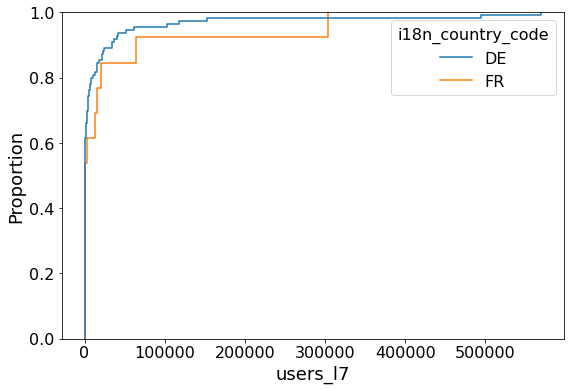

In [69]:
sns.ecdfplot(data=df_ambassador_subs, x="users_l7", hue="i18n_country_code")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

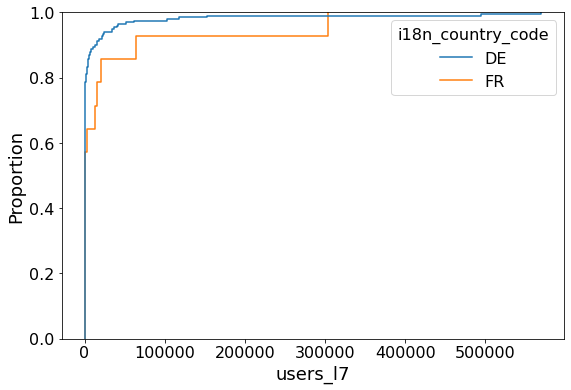

In [70]:
sns.ecdfplot(data=df_ambassador_subs.fillna(0), x="users_l7", hue="i18n_country_code")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

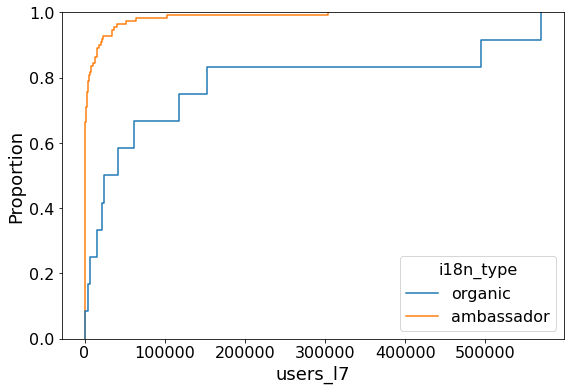

In [71]:
sns.ecdfplot(data=df_ambassador_subs, x="users_l7", hue="i18n_type")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

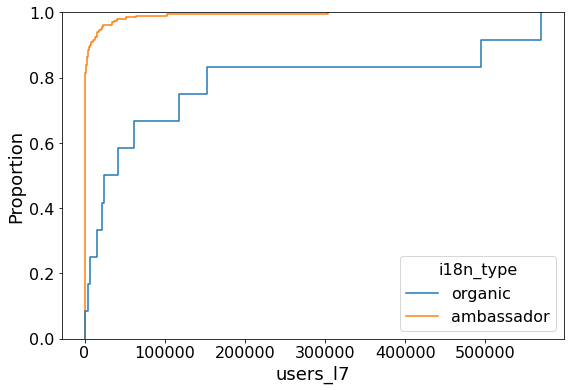

In [72]:
sns.ecdfplot(data=df_ambassador_subs.fillna(0), x="users_l7", hue="i18n_type")

# Check in a single table

put all the data in a single table so it's easier to see overlap & incremental gain per metric`m

## Definition with only a,b,c metrics

In [117]:
l_cols_base_merge = [
    # 'subreddit_id',
    'subreddit_name',
    'country_name',
]

l_cols_new_pcts = l_cols_base_merge + [
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'users_in_subreddit_from_country_l28',
    'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]

l_cols_lang_single = [c for c in l_cols_lang_disp_check if c != 'subreddit_id']

def show_geo_score_for_sub_single_table(
    subreddit: str,
    top_n_pct_subreddit: int = 5,
    top_n_pct_country: int = 5,
) -> None:
    sub_ = subreddit
    """display geo-relevance scores for input sub"""
    print(f"\n\n=== Subreddit: {sub_} ===")
    print(f"\nTop languages, by post [L28]") 
    display(
        style_df_numeric(
            df_lang_by_subreddit[df_lang_by_subreddit['subreddit_name'] == sub_]
            .sort_values(by=['language_rank'], ascending=True)
            [l_cols_lang_single]
            .head(5),
            rename_cols_for_display=True,
            int_cols=False,
            l_bar_simple=['b_users_percent_by_subreddit', 'c_users_percent_by_country'],
        ).hide_index()
    )
    
    # print(f"Geo-relevance default [40% users in subreddit, daily]")
    # col_geo_relevance = 
    df_base_ = (
        df_geo_baseline[df_geo_baseline['subreddit_name'] == sub_]
        [l_cols_base_merge]
        .assign(geo_relevance_default=True)
    )
    if len(df_base_) == 0:
        df_base_ = pd.DataFrame(columns=l_cols_base_merge + ['geo_relevance_default'])

    
    # print(f"\nTop by % of subreddit [L28]")
    s_top_pct_sub = (
        df_geo_new[df_geo_new['subreddit_name'] == sub_]
        .sort_values(by=['b_users_percent_by_subreddit'], ascending=False)
        ['country_name']
        .head(top_n_pct_subreddit)
    )
    
    # print(f"\nTop by % of country [L28]") 
    s_top_pct_country = (
        df_geo_new[df_geo_new['subreddit_name'] == sub_]
        .sort_values(by=['c_users_percent_by_country'], ascending=False)
        ['country_name']
        .head(top_n_pct_subreddit)
    )
    
    df_top_new_metrics = (
        df_geo_new[
            (df_geo_new['subreddit_name'] == sub_) &
            (df_geo_new['country_name'].isin(set(s_top_pct_sub.to_list()) | set(s_top_pct_country.to_list())))
        ]
        [l_cols_new_pcts]
    )
    
    # merge 2 dfs together
    df_merged = df_base_.merge(
        df_top_new_metrics,
        how='outer',
        on=l_cols_base_merge,
    ).fillna(False)
    df_merged = df_merged[
        reorder_array(l_cols_base_merge, df_merged.columns)
    ]
    
    display(
        style_df_numeric(
            df_merged
            .sort_values(by=['b_users_percent_by_subreddit'], ascending=False)
            .reset_index(drop=True)
            ,
            rename_cols_for_display=True,
            int_cols=False,
            pct_digits=3,
            l_bar_simple=['b_users_percent_by_subreddit', 'c_users_percent_by_country'],
        )  # .hide_index()
    )


## Definition with A,B,C E metrics (include standardized by country)

In [134]:
l_cols_base_merge = [
    # 'subreddit_id',
    'subreddit_name',
    'country_name',
]

l_cols_new_pcts_extra = l_cols_base_merge + [
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'd_users_percent_by_country_rank',
    'e_users_percent_by_country_standardized',
    'users_percent_by_country_avg',
    'num_of_countries_with_visits_l28',
    'users_in_subreddit_from_country_l28',
    # 'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]

l_cols_lang_single = [c for c in l_cols_lang_disp_check if c != 'subreddit_id']

def show_geo_score_for_sub_single_table_new_metrics(
    subreddit: str,
    top_n_pct_subreddit: int = 5,
    top_n_pct_country: int = 5,
    col_sort_by: str = 'e_users_percent_by_country_standardized',
    pct_cols='default',
) -> None:
    sub_ = subreddit
    """display geo-relevance scores for input sub
    include the standardized geo-relevance score
    """
    if pct_cols == 'default':
        pct_cols = [
            'b_users_percent_by_subreddit',
            'c_users_percent_by_country',
            'users_percent_by_country_avg',
        ]
        pct_labels = ''
    else:
        pct_labels = None

    print(f"\n\n=== Subreddit: {sub_} ===")
    print(f"\nTop languages, by post [L28]") 
    display(
        style_df_numeric(
            df_lang_by_subreddit[df_lang_by_subreddit['subreddit_name'] == sub_]
            .sort_values(by=['language_rank'], ascending=True)
            [l_cols_lang_single]
            .head(5),
            rename_cols_for_display=True,
            int_cols=False,
            l_bar_simple=['b_users_percent_by_subreddit',
                          'c_users_percent_by_country',
                          'd_users_percent_by_country_rank',
                         ],
        ).hide_index()
    )
    
    # print(f"Geo-relevance default [40% users in subreddit, daily]")
    # col_geo_relevance = 
    df_base_ = (
        df_geo_baseline[df_geo_baseline['subreddit_name'] == sub_]
        [l_cols_base_merge]
        .assign(geo_relevance_default=True)
    )
    if len(df_base_) == 0:
        df_base_ = pd.DataFrame(columns=l_cols_base_merge + ['geo_relevance_default'])

    
    # print(f"\nTop by % of subreddit [L28]")
    s_top_pct_sub = (
        df_geo_new[df_geo_new['subreddit_name'] == sub_]
        .sort_values(by=['b_users_percent_by_subreddit'], ascending=False)
        ['country_name']
        .head(top_n_pct_subreddit)
    )
    
    # print(f"\nTop by % of country [L28]") 
    s_top_pct_country = (
        df_geo_new[df_geo_new['subreddit_name'] == sub_]
        .sort_values(by=['c_users_percent_by_country'], ascending=False)
        ['country_name']
        .head(top_n_pct_subreddit)
    )
    
    # print(f"\nTop by % of country [L28]") 
    s_top_pct_country_standard = (
        df_geo_new[df_geo_new['subreddit_name'] == sub_]
        .sort_values(by=['e_users_percent_by_country_standardized'], ascending=False)
        ['country_name']
        .head(top_n_pct_subreddit)
    )
    
    df_top_new_metrics = (
        df_geo_new[
            (df_geo_new['subreddit_name'] == sub_) &
            (df_geo_new['country_name'].isin(
                set(s_top_pct_sub) | set(s_top_pct_country) |
                set(s_top_pct_country_standard)
            ))
        ]
        [l_cols_new_pcts_extra]
    )
    
    # merge 2 dfs together
    df_merged = df_base_.merge(
        df_top_new_metrics,
        how='outer',
        on=l_cols_base_merge,
    ).fillna({'country_name': 'NULL',}).fillna(False)
    
    df_merged = df_merged[
        reorder_array(l_cols_base_merge, df_merged.columns)
    ]
    
    display(
        style_df_numeric(
            df_merged
            .sort_values(by=[col_sort_by], ascending=False)
            .reset_index(drop=True)
            ,
            rename_cols_for_display=True,
            int_cols=False,
            pct_cols=pct_cols,
            pct_labels=pct_labels,
            pct_digits=3,
            l_bar_simple=['b_users_percent_by_subreddit', 
                          'c_users_percent_by_country',
                          'd_users_percent_by_country_rank',
                          'e_users_percent_by_country_standardized',
                         ],
        )  # .hide_index()
    )


## Show examples


In [135]:
# show_geo_score_for_sub_single_table(
#     'cricket',
#     top_n_pct_subreddit=9,
#     top_n_pct_country=9,
# )

In [155]:
show_geo_score_for_sub_single_table_new_metrics(
    'cricket',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: cricket ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
cricket,English,83.70%,1,"2,254",en
cricket,German,0.97%,2,26,de
cricket,Luxembourgish,0.93%,3,25,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,cricket,Australia,True,29.973%,2.366%,64,6.93,0.161%,177,"501,970","21,212,020"
1,cricket,India,False,21.793%,2.041%,36,5.91,0.161%,177,"364,975","17,881,562"
2,cricket,New Zealand,False,3.838%,1.811%,102,5.19,0.161%,177,"64,277","3,548,895"
3,cricket,Pakistan,False,0.934%,1.057%,63,2.82,0.161%,177,"15,636","1,478,792"
4,cricket,Sri Lanka,False,0.261%,0.999%,56,2.63,0.161%,177,"4,366","437,124"
5,cricket,Nepal,False,0.232%,0.899%,93,2.32,0.161%,177,"3,881","431,739"
6,cricket,Gibraltar,False,0.009%,0.803%,191,2.02,0.161%,177,151,"18,815"
7,cricket,South Africa,False,1.090%,0.758%,138,1.88,0.161%,177,"18,259","2,409,799"
8,cricket,Bangladesh,False,0.407%,0.666%,81,1.59,0.161%,177,"6,813","1,023,255"
9,cricket,United Kingdom,False,14.170%,0.534%,312,1.17,0.161%,177,"237,314","44,435,368"


In [137]:
show_geo_score_for_sub_single_table_new_metrics(
    'soccer',
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: soccer ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
soccer,English,62.39%,1,"4,508",en
soccer,Italian,2.60%,2,188,it
soccer,German,1.95%,3,141,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,soccer,Iceland,False,0.307%,10.173%,10,5.77,1.759%,197,"29,248","287,504"
1,soccer,Faroe Islands,False,0.024%,9.315%,10,5.19,1.759%,197,"2,251","24,165"
2,soccer,Gibraltar,False,0.013%,6.479%,7,3.24,1.759%,197,"1,219","18,815"
3,soccer,Croatia,False,0.768%,6.129%,7,3.00,1.759%,197,"73,051","1,191,830"
4,soccer,Portugal,False,1.702%,6.094%,10,2.98,1.759%,197,"161,978","2,657,942"
5,soccer,Norway,False,1.939%,5.968%,24,2.89,1.759%,197,"184,585","3,093,101"
6,soccer,Denmark,False,1.718%,5.576%,32,2.62,1.759%,197,"163,473","2,931,685"
7,soccer,Ireland,False,1.845%,4.928%,27,2.18,1.759%,197,"175,596","3,562,930"
8,soccer,Jersey,False,0.026%,4.492%,31,1.88,1.759%,197,"2,493","55,496"
9,soccer,United Kingdom,False,19.552%,4.188%,36,1.67,1.759%,197,"1,860,886","44,435,368"


In [138]:
show_geo_score_for_sub_single_table_new_metrics(
    'formula1',
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: formula1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
formula1,English,77.76%,1,"2,552",en
formula1,Norwegian,1.55%,2,51,no
formula1,Italian,1.34%,3,44,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,formula1,Netherlands,False,6.084%,6.545%,15,4.97,1.176%,198,"574,558","8,778,610"
1,formula1,Åland Islands,False,0.009%,5.522%,31,4.02,1.176%,198,856,"15,503"
2,formula1,Finland,False,1.505%,4.092%,44,2.70,1.176%,198,"142,180","3,474,546"
3,formula1,Jersey,False,0.023%,3.988%,38,2.60,1.176%,198,"2,213","55,496"
4,formula1,Norway,False,1.200%,3.665%,44,2.30,1.176%,198,"113,368","3,093,101"
5,formula1,Guernsey,False,0.013%,3.620%,42,2.26,1.176%,198,"1,195","33,007"
6,formula1,Portugal,False,1.002%,3.562%,30,2.21,1.176%,198,"94,676","2,657,942"
7,formula1,Ireland,False,1.261%,3.343%,44,2.01,1.176%,198,"119,099","3,562,930"
8,formula1,Estonia,False,0.205%,3.330%,55,1.99,1.176%,198,"19,344","580,906"
9,formula1,Sweden,False,2.005%,3.161%,56,1.84,1.176%,198,"189,391","5,991,932"


In [139]:
for sub_ in l_subs_to_check1:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
    )



=== Subreddit: rugbyunion ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rugbyunion,English,78.03%,1,856,en
rugbyunion,Norwegian,1.46%,2,16,no
rugbyunion,Danish,1.46%,3,16,da


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rugbyunion,Ireland,False,11.262%,1.589%,108,8.62,0.076%,150,"56,609","3,562,930"
1,rugbyunion,Jersey,False,0.077%,0.696%,264,3.53,0.076%,150,386,"55,496"
2,rugbyunion,New Zealand,False,4.257%,0.603%,298,3.00,0.076%,150,"21,398","3,548,895"
3,rugbyunion,United Kingdom,True,49.612%,0.561%,296,2.76,0.076%,150,"249,369","44,435,368"
4,rugbyunion,Fiji,False,0.036%,0.546%,161,2.68,0.076%,150,181,"33,131"
5,rugbyunion,Guernsey,False,0.034%,0.521%,342,2.54,0.076%,150,172,"33,007"
6,rugbyunion,South Africa,False,2.383%,0.497%,210,2.40,0.076%,150,"11,976","2,409,799"
7,rugbyunion,Australia,False,5.664%,0.134%,"1,045",0.33,0.076%,150,"28,470","21,212,020"
8,rugbyunion,France,False,2.555%,0.114%,750,0.22,0.076%,150,"12,842","11,275,674"
9,rugbyunion,Canada,False,3.060%,0.037%,"3,176",-0.22,0.076%,150,"15,383","41,410,610"




=== Subreddit: rugbyaustralia ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rugbyaustralia,English,58.33%,1,7,en
rugbyaustralia,Dutch,16.67%,2,2,nl
rugbyaustralia,None,8.33%,3,1,be


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rugbyaustralia,Fiji,False,0.326%,0.015%,"4,128",4.14,0.001%,20,5,"33,131"
1,rugbyaustralia,Australia,True,43.416%,0.003%,"13,582",0.58,0.001%,20,666,"21,212,020"
2,rugbyaustralia,United Kingdom,True,24.511%,0.001%,"28,074",-0.10,0.001%,20,376,"44,435,368"
3,rugbyaustralia,Portugal,False,0.913%,0.001%,"29,878",-0.20,0.001%,20,14,"2,657,942"
4,rugbyaustralia,Switzerland,False,0.587%,0.000%,"38,382",-0.26,0.001%,20,9,"2,755,829"
5,rugbyaustralia,Spain,False,0.522%,0.000%,"46,964",-0.32,0.001%,20,8,"6,148,262"
6,rugbyaustralia,Canada,False,2.868%,0.000%,"55,045",-0.32,0.001%,20,44,"41,410,610"
7,rugbyaustralia,United States,False,12.451%,0.000%,"66,827",-0.34,0.001%,20,191,"295,349,042"




=== Subreddit: bundesliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
bundesliga,English,44.44%,1,52,en
bundesliga,German,35.90%,2,42,de
bundesliga,French,4.27%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,bundesliga,Germany,True,66.891%,0.219%,566,8.96,0.010%,112,"51,936","23,730,177"
1,bundesliga,Grenada,False,0.017%,0.076%,"1,377",2.83,0.010%,112,13,"17,054"
2,bundesliga,Liechtenstein,False,0.009%,0.058%,"1,853",2.07,0.010%,112,7,"11,987"
3,bundesliga,Luxembourg,False,0.167%,0.047%,"2,162",1.60,0.010%,112,130,"274,197"
4,bundesliga,Northern Mariana Islands,False,0.010%,0.046%,"2,082",1.55,0.010%,112,8,"17,274"
5,bundesliga,Åland Islands,False,0.009%,0.045%,"2,655",1.50,0.010%,112,7,"15,503"
6,bundesliga,Austria,False,1.409%,0.042%,"2,707",1.35,0.010%,112,"1,094","2,622,613"
7,bundesliga,Switzerland,False,0.923%,0.026%,"3,518",0.68,0.010%,112,717,"2,755,829"
8,bundesliga,United Kingdom,False,3.356%,0.006%,"10,481",-0.19,0.010%,112,"2,606","44,435,368"
9,bundesliga,Australia,False,1.014%,0.004%,"12,438",-0.28,0.010%,112,787,"21,212,020"


In [140]:
for sub_ in l_subs_to_check2:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
    )



=== Subreddit: premierleague ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
premierleague,English,91.36%,1,782,en
premierleague,French,2.57%,2,22,fr
premierleague,Filipino,0.58%,3,5,fil


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,premierleague,Iceland,False,0.272%,0.864%,259,4.61,0.162%,184,"2,483","287,504"
1,premierleague,Åland Islands,False,0.011%,0.651%,319,3.22,0.162%,184,101,"15,503"
2,premierleague,Ireland,False,2.538%,0.651%,256,3.22,0.162%,184,"23,210","3,562,930"
3,premierleague,Isle of Man,False,0.039%,0.619%,274,3.00,0.162%,184,354,"57,187"
4,premierleague,United Kingdom,False,29.285%,0.603%,276,2.90,0.162%,184,"267,805","44,435,368"
5,premierleague,Jersey,False,0.036%,0.595%,304,2.84,0.162%,184,330,"55,496"
6,premierleague,Greenland,False,0.010%,0.545%,268,2.52,0.162%,184,89,"16,320"
7,premierleague,Norway,False,1.568%,0.464%,393,1.98,0.162%,184,"14,342","3,093,101"
8,premierleague,India,False,4.818%,0.246%,384,0.55,0.162%,184,"44,055","17,881,562"
9,premierleague,Australia,False,5.181%,0.223%,663,0.40,0.162%,184,"47,381","21,212,020"




=== Subreddit: reddevils ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
reddevils,English,75.80%,1,683,en
reddevils,Italian,2.55%,2,23,it
reddevils,Norwegian,1.66%,3,15,no


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,reddevils,Iceland,False,0.589%,3.406%,62,7.53,0.333%,187,"9,793","287,504"
1,reddevils,Faroe Islands,False,0.034%,2.342%,95,4.92,0.333%,187,566,"24,165"
2,reddevils,Norway,False,3.609%,1.940%,103,3.94,0.333%,187,"60,016","3,093,101"
3,reddevils,Ireland,False,3.886%,1.814%,88,3.63,0.333%,187,"64,636","3,562,930"
4,reddevils,Gibraltar,False,0.014%,1.254%,121,2.26,0.333%,187,236,"18,815"
5,reddevils,Mauritius,False,0.107%,1.181%,61,2.08,0.333%,187,"1,775","150,309"
6,reddevils,Guernsey,False,0.023%,1.169%,159,2.05,0.333%,187,386,"33,007"
7,reddevils,United Kingdom,False,27.387%,1.025%,173,1.69,0.333%,187,"455,496","44,435,368"
8,reddevils,India,False,5.769%,0.537%,185,0.50,0.333%,187,"95,955","17,881,562"
9,reddevils,Australia,False,4.081%,0.320%,475,-0.03,0.333%,187,"67,878","21,212,020"




=== Subreddit: liverpoolfc ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,liverpoolfc,Iceland,False,0.613%,3.039%,72,7.87,0.262%,189,"8,736","287,504"
1,liverpoolfc,Isle of Man,False,0.067%,1.665%,100,3.98,0.262%,189,952,"57,187"
2,liverpoolfc,Ireland,False,3.788%,1.516%,112,3.56,0.262%,189,"54,023","3,562,930"
3,liverpoolfc,Faroe Islands,False,0.024%,1.436%,159,3.33,0.262%,189,347,"24,165"
4,liverpoolfc,Gibraltar,False,0.017%,1.323%,112,3.01,0.262%,189,249,"18,815"
5,liverpoolfc,Guernsey,False,0.028%,1.206%,155,2.68,0.262%,189,398,"33,007"
6,liverpoolfc,Jersey,False,0.045%,1.150%,166,2.52,0.262%,189,638,"55,496"
7,liverpoolfc,Norway,False,2.344%,1.081%,176,2.32,0.262%,189,"33,427","3,093,101"
8,liverpoolfc,United Kingdom,False,30.039%,0.964%,184,1.99,0.262%,189,"428,368","44,435,368"
9,liverpoolfc,Australia,False,4.922%,0.331%,459,0.20,0.262%,189,"70,193","21,212,020"




=== Subreddit: ligue1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligue1,French,73.68%,1,56,fr
ligue1,English,11.84%,2,9,en
ligue1,Portuguese,3.95%,3,3,pt


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ligue1,French Guiana,False,0.087%,0.056%,"1,408",4.29,0.004%,51,6,"10,686"
1,ligue1,New Caledonia,False,0.116%,0.051%,"1,584",3.86,0.004%,51,8,"15,713"
2,ligue1,France,True,62.700%,0.038%,"2,032",2.81,0.004%,51,"4,320","11,275,674"
3,ligue1,Madagascar,False,0.087%,0.025%,"2,408",1.67,0.004%,51,6,"24,392"
4,ligue1,Martinique,False,0.073%,0.017%,"3,610",1.03,0.004%,51,5,"29,641"
5,ligue1,Luxembourg,False,0.363%,0.009%,"7,161",0.38,0.004%,51,25,"274,197"
6,ligue1,Switzerland,False,0.885%,0.002%,"16,462",-0.19,0.004%,51,61,"2,755,829"
7,ligue1,Canada,False,4.659%,0.001%,"28,782",-0.31,0.004%,51,321,"41,410,610"
8,ligue1,United Kingdom,False,3.962%,0.001%,"31,930",-0.32,0.004%,51,273,"44,435,368"
9,ligue1,Germany,False,1.640%,0.000%,"31,071",-0.33,0.004%,51,113,"23,730,177"


In [141]:
for sub_ in l_subs_to_check3:
    show_geo_score_for_sub_single_table_new_metrics(
        sub_,
        top_n_pct_subreddit=7,
        top_n_pct_country=7,
    )



=== Subreddit: laliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
laliga,English,75.83%,1,91,en
laliga,Spanish,3.33%,2,4,es
laliga,French,2.50%,3,3,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,laliga,Sudan,False,0.077%,0.012%,"4,362",4.92,0.002%,94,5,"43,019"
1,laliga,Malta,False,0.340%,0.011%,"6,482",4.54,0.002%,94,22,"201,872"
2,laliga,Spain,False,6.848%,0.007%,"7,320",2.66,0.002%,94,443,"6,148,262"
3,laliga,Nepal,False,0.433%,0.006%,"6,227",2.29,0.002%,94,28,"431,739"
4,laliga,Lebanon,False,0.294%,0.006%,"7,780",2.24,0.002%,94,19,"297,672"
5,laliga,Iceland,False,0.263%,0.006%,"10,524",2.00,0.002%,94,17,"287,504"
6,laliga,XK,False,0.077%,0.005%,"9,634",1.67,0.002%,94,5,"94,780"
7,laliga,India,False,7.698%,0.003%,"10,715",0.40,0.002%,94,498,"17,881,562"
8,laliga,United Kingdom,False,7.977%,0.001%,"24,495",-0.43,0.002%,94,516,"44,435,368"
9,laliga,Canada,False,6.322%,0.001%,"26,037",-0.52,0.002%,94,409,"41,410,610"




=== Subreddit: barca ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
barca,English,81.03%,1,551,en
barca,Italian,1.76%,2,12,it
barca,Spanish,1.76%,3,12,es


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,barca,Tajikistan,False,0.010%,0.593%,80,4.26,0.130%,176,42,"7,087"
1,barca,Gibraltar,False,0.025%,0.553%,261,3.90,0.130%,176,104,"18,815"
2,barca,Sierra Leone,False,0.010%,0.503%,67,3.44,0.130%,176,41,"8,147"
3,barca,Slovenia,False,0.677%,0.451%,377,2.96,0.130%,176,"2,841","630,025"
4,barca,Mozambique,False,0.029%,0.441%,145,2.87,0.130%,176,121,"27,442"
5,barca,XK,False,0.096%,0.423%,518,2.70,0.130%,176,401,"94,780"
6,barca,Ghana,False,0.166%,0.392%,122,2.41,0.130%,176,696,"177,716"
7,barca,India,False,11.104%,0.261%,363,1.21,0.130%,176,"46,614","17,881,562"
8,barca,Spain,False,2.637%,0.180%,543,0.46,0.130%,176,"11,069","6,148,262"
9,barca,Netherlands,False,3.743%,0.179%,870,0.45,0.130%,176,"15,713","8,778,610"




=== Subreddit: ligamx ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligamx,English,38.06%,1,295,en
ligamx,Spanish,29.94%,2,232,es
ligamx,Italian,2.71%,3,21,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,ligamx,Mexico,False,16.437%,0.238%,296,8.87,0.007%,85,"20,475","8,614,400"
1,ligamx,United States,False,75.525%,0.032%,"3,816",0.95,0.007%,85,"94,080","295,349,042"
2,ligamx,Aruba,False,0.010%,0.029%,"3,182",0.86,0.007%,85,12,"40,696"
3,ligamx,Belize,False,0.010%,0.024%,"3,362",0.66,0.007%,85,12,"49,604"
4,ligamx,El Salvador,False,0.051%,0.019%,"2,514",0.47,0.007%,85,64,"329,292"
5,ligamx,Cuba,False,0.008%,0.019%,"2,434",0.46,0.007%,85,10,"52,286"
6,ligamx,Chile,False,0.112%,0.006%,"7,051",-0.04,0.007%,85,140,"2,311,951"
7,ligamx,Canada,False,1.515%,0.005%,"11,923",-0.10,0.007%,85,"1,887","41,410,610"
8,ligamx,Brazil,False,0.316%,0.003%,"9,957",-0.17,0.007%,85,394,"14,525,140"
9,ligamx,United Kingdom,False,0.938%,0.003%,"16,294",-0.17,0.007%,85,"1,169","44,435,368"




=== Subreddit: seriea ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
seriea,English,76.98%,1,107,en
seriea,Italian,3.60%,2,5,it
seriea,French,3.60%,3,5,fr


,subreddit name,country name,geo relevance default,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,seriea,Grenada,False,0.049%,0.047%,"2,102",5.36,0.005%,102,8,"17,054"
1,seriea,Malta,False,0.517%,0.042%,"2,391",4.75,0.005%,102,85,"201,872"
2,seriea,XK,False,0.201%,0.035%,"3,827",3.82,0.005%,102,33,"94,780"
3,seriea,Italy,False,13.868%,0.031%,"2,543",3.37,0.005%,102,"2,282","7,283,606"
4,seriea,Albania,False,0.474%,0.029%,"2,584",3.11,0.005%,102,78,"266,668"
5,seriea,Macedonia,False,0.231%,0.014%,"4,994",1.13,0.005%,102,38,"275,464"
6,seriea,Croatia,False,0.705%,0.010%,"6,804",0.61,0.005%,102,116,"1,191,830"
7,seriea,Canada,False,12.142%,0.005%,"11,515",-0.02,0.005%,102,"1,998","41,410,610"
8,seriea,United Kingdom,False,8.222%,0.003%,"15,065",-0.24,0.005%,102,"1,353","44,435,368"
9,seriea,Australia,False,3.342%,0.003%,"15,021",-0.30,0.005%,102,550,"21,212,020"


# Rank by country

In [82]:
# df_geo_new.columns.to_list()

In [146]:
l_cols_country_disp = [
    'subreddit_name',
    # 'subreddit_id',
    # 'geo_country_code',
    'country_name',
    # 'geo_region',
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'd_users_percent_by_country_rank',
    'e_users_percent_by_country_standardized',
    'users_percent_by_country_avg',
    # 'users_percent_by_country_stdev',
    'num_of_countries_with_visits_l28',
    'users_in_subreddit_from_country_l28',
    'total_users_in_country_l28',
#     'total_users_in_subreddit_l28',
#     'over_18',
#     'verdict',
#     'type',
]

def display_top_subs_in_country(
    country: str,
    col_sort: str,
    top_n: int = 20,
):
    """Display top subs for each country sorted by input col"""
    display(
        style_df_numeric(
            df_geo_new
            [df_geo_new['country_name'] == country]
            .sort_values(by=[col_sort], ascending=False)
            [l_cols_country_disp]
            .head(top_n)
            .reset_index(drop=True)
            ,
            rename_cols_for_display=True,
            int_cols=False,
            pct_digits=3,
            pct_cols=['b_users_percent_by_subreddit', 
                      'c_users_percent_by_country', 
                      'users_percent_by_country_avg',
                     ],
            pct_labels='',
            l_bar_simple=['b_users_percent_by_subreddit', 
                          'c_users_percent_by_country',
                          'e_users_percent_by_country_standardized',
                         ],
        )  # .hide_index()
    )

In [147]:
# country_ = 'Portugal'
# col_sort = 'c_users_percent_by_country'
# print(f"Top 20 subreddits by: {col_sort}")
# display_top_subs_in_country(
#     country=country_,
#     col_sort=col_sort,
#     top_n=20,
# )

In [148]:
# country_ = 'Portugal'
# col_sort = 'e_users_percent_by_country_standardized'
# print(f"Top 20 subreddits by: {col_sort}")
# display_top_subs_in_country(
#     country=country_,
#     col_sort=col_sort,
#     top_n=20,
# )

In [152]:
n_subs = 100
country_ = 'United States'
for col_ in ['c_users_percent_by_country', 'e_users_percent_by_country_standardized']:
    print(f"Top {n_subs} subreddits by: {col_}")
    display_top_subs_in_country(
        country=country_,
        col_sort=col_,
        top_n=n_subs,
    )

Top 100 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,United States,54.317%,20.647%,1,1.73,10.703%,199,"60,979,678","295,349,042"
1,antiwork,United States,61.840%,14.936%,2,2.73,4.854%,199,"44,113,319","295,349,042"
2,pics,United States,60.389%,11.341%,3,2.53,4.291%,199,"33,495,263","295,349,042"
3,news,United States,68.064%,9.339%,4,3.66,2.516%,199,"27,583,600","295,349,042"
4,tinder,United States,54.936%,8.269%,5,1.75,3.697%,199,"24,421,051","295,349,042"
5,funny,United States,56.365%,7.986%,6,2.07,3.538%,199,"23,587,556","295,349,042"
6,interestingasfuck,United States,53.051%,7.749%,7,1.58,3.933%,199,"22,887,257","295,349,042"
7,facepalm,United States,54.439%,7.696%,8,1.62,3.833%,199,"22,728,922","295,349,042"
8,whitepeopletwitter,United States,64.888%,6.937%,9,2.91,2.223%,199,"20,487,817","295,349,042"
9,holup,United States,50.668%,6.850%,10,1.14,4.276%,199,"20,231,635","295,349,042"


Top 100 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,doordash,United States,90.606%,0.465%,338,10.40,0.025%,149,"1,373,719","295,349,042"
1,walmart,United States,91.770%,0.334%,459,9.98,0.016%,143,"985,135","295,349,042"
2,doordash_drivers,United States,92.185%,0.273%,582,9.95,0.014%,130,"805,775","295,349,042"
3,portland,United States,94.918%,0.323%,476,9.76,0.018%,135,"954,396","295,349,042"
4,losangeles,United States,90.339%,0.503%,307,9.76,0.043%,166,"1,486,375","295,349,042"
5,saltlakecity,United States,96.715%,0.160%,969,9.35,0.007%,107,"472,398","295,349,042"
6,houston,United States,95.516%,0.308%,510,9.24,0.018%,137,"908,251","295,349,042"
7,traderjoes,United States,96.715%,0.177%,876,9.04,0.008%,118,"523,121","295,349,042"
8,target,United States,88.621%,0.418%,371,8.95,0.038%,169,"1,233,216","295,349,042"
9,columbus,United States,97.153%,0.176%,882,8.86,0.008%,113,"520,864","295,349,042"


In [151]:
n_subs = 20
for country_ in l_i18n_target_countries:
    for col_ in ['c_users_percent_by_country', 'e_users_percent_by_country_standardized']:
        print(f"Top {n_subs} subreddits by: {col_}")
        display_top_subs_in_country(
            country=country_,
            col_sort=col_,
            top_n=n_subs,
        )

Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de,Germany,81.810%,13.696%,1,11.99,0.230%,181,"3,250,104","23,730,177"
1,askreddit,Germany,2.825%,13.364%,2,0.46,10.703%,199,"3,171,260","23,730,177"
2,ich_iel,Germany,73.016%,12.259%,3,11.50,0.249%,180,"2,909,076","23,730,177"
3,finanzen,Germany,92.285%,6.851%,4,10.93,0.105%,137,"1,625,702","23,730,177"
4,memes,Germany,5.468%,6.777%,5,1.83,3.669%,199,"1,608,173","23,730,177"
5,holup,Germany,3.990%,6.714%,6,1.08,4.276%,199,"1,593,262","23,730,177"
6,tinder,Germany,3.436%,6.438%,7,1.05,3.697%,199,"1,527,648","23,730,177"
7,pics,Germany,2.664%,6.226%,8,0.69,4.291%,199,"1,477,391","23,730,177"
8,interestingasfuck,Germany,3.359%,6.106%,9,0.90,3.933%,199,"1,449,041","23,730,177"
9,antiwork,Germany,2.020%,6.072%,10,0.33,4.854%,199,"1,440,852","23,730,177"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,de,Germany,81.810%,13.696%,1,11.99,0.230%,181,"3,250,104","23,730,177"
1,germany,Germany,58.717%,3.671%,26,11.91,0.149%,182,"871,239","23,730,177"
2,berlin,Germany,68.879%,1.353%,90,11.52,0.047%,148,"321,141","23,730,177"
3,ich_iel,Germany,73.016%,12.259%,3,11.50,0.249%,180,"2,909,076","23,730,177"
4,finanzen,Germany,92.285%,6.851%,4,10.93,0.105%,137,"1,625,702","23,730,177"
5,askagerman,Germany,69.683%,0.464%,280,10.90,0.015%,127,"110,198","23,730,177"
6,fragreddit,Germany,91.454%,4.512%,15,10.62,0.076%,132,"1,070,817","23,730,177"
7,wasletztepreis,Germany,89.924%,4.020%,19,10.19,0.071%,131,"953,913","23,730,177"
8,beziehungen,Germany,97.842%,4.528%,14,10.03,0.057%,103,"1,074,574","23,730,177"
9,munich,Germany,76.635%,0.430%,302,9.99,0.016%,115,"102,004","23,730,177"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,austria,Austria,77.789%,29.543%,1,11.74,0.268%,141,"774,802","2,622,613"
1,askreddit,Austria,0.388%,16.607%,2,1.03,10.703%,199,"435,532","2,622,613"
2,antiwork,Austria,0.377%,10.257%,3,1.47,4.854%,199,"269,000","2,622,613"
3,tinder,Austria,0.507%,8.595%,4,1.87,3.697%,199,"225,406","2,622,613"
4,pics,Austria,0.378%,7.986%,5,1.33,4.291%,199,"209,441","2,622,613"
5,interestingasfuck,Austria,0.465%,7.647%,6,1.53,3.933%,199,"200,550","2,622,613"
6,holup,Austria,0.502%,7.645%,7,1.49,4.276%,199,"200,499","2,622,613"
7,facepalm,Austria,0.470%,7.486%,8,1.53,3.833%,199,"196,334","2,622,613"
8,memes,Austria,0.619%,6.941%,9,1.93,3.669%,199,"182,046","2,622,613"
9,gaming,Austria,0.466%,6.738%,10,1.60,3.365%,199,"176,701","2,622,613"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,austria,Austria,77.789%,29.543%,1,11.74,0.268%,141,"774,802","2,622,613"
1,wien,Austria,82.912%,5.735%,13,9.93,0.070%,101,"150,414","2,622,613"
2,aeiou,Austria,87.251%,4.720%,20,9.16,0.062%,86,"123,777","2,622,613"
3,saradodevskaonlyfans,Austria,59.288%,1.854%,79,8.59,0.037%,80,"48,636","2,622,613"
4,okoidawappler,Austria,80.797%,1.426%,110,7.74,0.026%,62,"37,406","2,622,613"
5,phantomborders,Austria,19.352%,0.029%,"3,477",7.25,0.001%,55,765,"2,622,613"
6,defiblockchain,Austria,8.522%,0.086%,"1,488",7.19,0.005%,86,"2,260","2,622,613"
7,bitpanda,Austria,27.464%,0.176%,798,7.18,0.007%,71,"4,609","2,622,613"
8,graz,Austria,94.241%,1.824%,82,7.14,0.036%,53,"47,845","2,622,613"
9,trams,Austria,20.890%,0.045%,"2,528",6.82,0.002%,57,"1,192","2,622,613"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,Switzerland,0.375%,15.266%,1,0.79,10.703%,199,"420,710","2,755,829"
1,antiwork,Switzerland,0.358%,9.277%,2,1.20,4.854%,199,"255,653","2,755,829"
2,tinder,Switzerland,0.510%,8.230%,3,1.73,3.697%,199,"226,812","2,755,829"
3,pics,Switzerland,0.377%,7.586%,4,1.18,4.291%,199,"209,044","2,755,829"
4,switzerland,Switzerland,63.409%,7.071%,5,11.28,0.095%,146,"194,854","2,755,829"
5,facepalm,Switzerland,0.453%,6.867%,6,1.27,3.833%,199,"189,245","2,755,829"
6,interestingasfuck,Switzerland,0.431%,6.742%,7,1.16,3.933%,199,"185,810","2,755,829"
7,holup,Switzerland,0.459%,6.656%,8,1.05,4.276%,199,"183,428","2,755,829"
8,funny,Switzerland,0.403%,6.115%,9,1.20,3.538%,199,"168,513","2,755,829"
9,memes,Switzerland,0.517%,5.517%,10,1.09,3.669%,199,"152,050","2,755,829"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,switzerland,Switzerland,63.409%,7.071%,5,11.28,0.095%,146,"194,854","2,755,829"
1,askswitzerland,Switzerland,58.259%,1.977%,68,10.51,0.032%,118,"54,473","2,755,829"
2,zurich,Switzerland,80.983%,2.726%,40,10.01,0.036%,104,"75,121","2,755,829"
3,ethz,Switzerland,73.057%,0.927%,146,9.10,0.016%,88,"25,554","2,755,829"
4,switzerlandisfake,Switzerland,38.328%,0.190%,655,8.37,0.005%,83,"5,231","2,755,829"
5,buenzli,Switzerland,79.676%,3.132%,34,7.86,0.063%,91,"86,309","2,755,829"
6,remarkabletablet,Switzerland,4.962%,0.332%,391,7.85,0.025%,138,"9,137","2,755,829"
7,geneva,Switzerland,43.453%,0.115%,"1,041",7.65,0.004%,65,"3,156","2,755,829"
8,schweiz,Switzerland,81.868%,0.631%,196,7.54,0.013%,60,"17,388","2,755,829"
9,threema,Switzerland,9.928%,0.019%,"4,383",7.11,0.002%,63,523,"2,755,829"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,India,1.750%,10.988%,1,0.05,10.703%,199,"1,964,738","17,881,562"
1,india,India,56.437%,8.207%,2,12.86,0.200%,191,"1,467,550","17,881,562"
2,indiandankmemes,India,78.569%,8.122%,3,12.78,0.123%,174,"1,452,315","17,881,562"
3,holup,India,2.911%,6.500%,4,0.98,4.276%,199,"1,162,325","17,881,562"
4,memes,India,3.906%,6.423%,5,1.62,3.669%,199,"1,148,588","17,881,562"
5,dankinindia,India,82.100%,4.462%,6,12.31,0.063%,157,"797,956","17,881,562"
6,interestingasfuck,India,1.784%,4.303%,7,0.15,3.933%,199,"769,464","17,881,562"
7,bollyblindsngossip,India,64.134%,4.205%,8,10.80,0.124%,164,"751,918","17,881,562"
8,unexpected,India,2.905%,4.193%,9,0.78,2.912%,199,"749,799","17,881,562"
9,dankmemes,India,3.977%,3.836%,10,1.53,2.020%,199,"685,853","17,881,562"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,indiangaming,India,66.138%,2.762%,25,12.91,0.068%,173,"493,972","17,881,562"
1,india,India,56.437%,8.207%,2,12.86,0.200%,191,"1,467,550","17,881,562"
2,indiandankmemes,India,78.569%,8.122%,3,12.78,0.123%,174,"1,452,315","17,881,562"
3,indiangirlsontinder,India,66.202%,2.972%,21,12.64,0.056%,166,"531,418","17,881,562"
4,dankinindia,India,82.100%,4.462%,6,12.31,0.063%,157,"797,956","17,881,562"
5,indiaspeaks,India,69.754%,2.971%,22,11.91,0.058%,153,"531,334","17,881,562"
6,chodi,India,67.749%,1.820%,48,11.55,0.039%,146,"325,505","17,881,562"
7,saimansays,India,84.104%,3.211%,19,11.43,0.048%,140,"574,115","17,881,562"
8,indianskincareaddicts,India,55.895%,0.667%,142,11.28,0.024%,148,"119,331","17,881,562"
9,bangalore,India,85.863%,2.576%,26,10.86,0.037%,122,"460,647","17,881,562"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,france,France,75.701%,15.949%,1,10.33,0.435%,186,"1,798,323","11,275,674"
1,askreddit,France,0.850%,8.458%,2,-0.39,10.703%,199,"953,729","11,275,674"
2,rance,France,79.008%,6.982%,3,11.92,0.140%,174,"787,276","11,275,674"
3,antiwork,France,0.772%,4.884%,4,0.01,4.854%,199,"550,722","11,275,674"
4,tinder,France,1.136%,4.478%,5,0.30,3.697%,199,"504,880","11,275,674"
5,holup,France,1.190%,4.213%,6,-0.03,4.276%,199,"475,095","11,275,674"
6,facepalm,France,1.107%,4.100%,7,0.11,3.833%,199,"462,335","11,275,674"
7,interestingasfuck,France,1.069%,4.092%,8,0.07,3.933%,199,"461,350","11,275,674"
8,pics,France,0.790%,3.887%,9,-0.14,4.291%,199,"438,326","11,275,674"
9,memes,France,1.400%,3.651%,10,-0.01,3.669%,199,"411,641","11,275,674"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,rance,France,79.008%,6.982%,3,11.92,0.140%,174,"787,276","11,275,674"
1,paris,France,77.150%,2.842%,17,11.84,0.052%,151,"320,461","11,275,674"
2,france,France,75.701%,15.949%,1,10.33,0.435%,186,"1,798,323","11,275,674"
3,frenchmemes,France,84.455%,0.483%,176,9.08,0.013%,100,"54,503","11,275,674"
4,askfrance,France,72.533%,0.429%,198,8.89,0.014%,111,"48,334","11,275,674"
5,socialparis,France,85.048%,0.228%,379,8.02,0.006%,75,"25,749","11,275,674"
6,strasbourg,France,89.239%,0.199%,449,7.03,0.005%,52,"22,399","11,275,674"
7,lyon,France,84.917%,0.227%,383,7.02,0.008%,71,"25,582","11,275,674"
8,vdm,France,95.547%,0.608%,132,6.86,0.025%,57,"68,575","11,275,674"
9,enculerlesvoitures,France,73.392%,0.095%,908,6.75,0.004%,60,"10,705","11,275,674"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,Spain,0.486%,8.869%,1,-0.32,10.703%,199,"545,301","6,148,262"
1,antiwork,Spain,0.418%,4.853%,2,-0.00,4.854%,199,"298,372","6,148,262"
2,askspain,Spain,65.640%,4.403%,3,11.74,0.064%,149,"270,683","6,148,262"
3,orslokx,Spain,61.479%,4.370%,4,8.38,0.169%,118,"268,668","6,148,262"
4,tinder,Spain,0.591%,4.271%,5,0.22,3.697%,199,"262,598","6,148,262"
5,interestingasfuck,Spain,0.577%,4.046%,6,0.05,3.933%,199,"248,753","6,148,262"
6,holup,Spain,0.602%,3.912%,7,-0.16,4.276%,199,"240,506","6,148,262"
7,gaming,Spain,0.628%,3.871%,8,0.24,3.365%,199,"237,977","6,148,262"
8,pics,Spain,0.407%,3.670%,9,-0.22,4.291%,199,"225,639","6,148,262"
9,facepalm,Spain,0.524%,3.558%,10,-0.11,3.833%,199,"218,765","6,148,262"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askspain,Spain,65.640%,4.403%,3,11.74,0.064%,149,"270,683","6,148,262"
1,spain,Spain,62.677%,2.364%,22,11.16,0.043%,134,"145,326","6,148,262"
2,madrid,Spain,69.061%,0.915%,81,10.34,0.016%,111,"56,280","6,148,262"
3,barcelona,Spain,59.241%,0.891%,85,10.08,0.021%,120,"54,756","6,148,262"
4,fatvazquez,Spain,43.510%,1.150%,66,9.36,0.046%,135,"70,724","6,148,262"
5,es,Spain,66.066%,0.842%,97,9.29,0.023%,94,"51,782","6,148,262"
6,valencia,Spain,70.010%,0.273%,343,8.61,0.007%,78,"16,799","6,148,262"
7,orslokx,Spain,61.479%,4.370%,4,8.38,0.169%,118,"268,668","6,148,262"
8,bikiniworld,Spain,14.292%,0.046%,"1,926",8.15,0.004%,92,"2,815","6,148,262"
9,podemos,Spain,49.553%,0.196%,484,8.09,0.009%,83,"12,032","6,148,262"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,brasil,Brazil,75.471%,8.726%,1,12.58,0.122%,168,"1,267,455","14,525,140"
1,braziliangirls,Brazil,80.688%,5.566%,2,12.63,0.104%,176,"808,475","14,525,140"
2,askreddit,Brazil,0.582%,4.495%,3,-1.08,10.703%,199,"652,870","14,525,140"
3,desabafos,Brazil,88.786%,4.255%,4,10.46,0.068%,120,"618,003","14,525,140"
4,sexualidade,Brazil,91.171%,2.834%,5,10.42,0.046%,121,"411,710","14,525,140"
5,brasilivre,Brazil,79.765%,2.586%,6,10.65,0.045%,120,"375,614","14,525,140"
6,unexpected,Brazil,1.450%,2.578%,7,-0.20,2.912%,199,"374,410","14,525,140"
7,clubdosfasbrasil,Brazil,84.737%,2.543%,8,11.18,0.048%,134,"369,405","14,525,140"
8,gaming,Brazil,0.893%,2.329%,9,-0.49,3.365%,199,"338,309","14,525,140"
9,interestingasfuck,Brazil,0.776%,2.304%,10,-0.67,3.933%,199,"334,601","14,525,140"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,braziliangirls,Brazil,80.688%,5.566%,2,12.63,0.104%,176,"808,475","14,525,140"
1,brasil,Brazil,75.471%,8.726%,1,12.58,0.122%,168,"1,267,455","14,525,140"
2,ithadtobebrazil,Brazil,36.289%,0.418%,166,11.38,0.018%,145,"60,697","14,525,140"
3,clubdosfasbrasil,Brazil,84.737%,2.543%,8,11.18,0.048%,134,"369,405","14,525,140"
4,brasilivre,Brazil,79.765%,2.586%,6,10.65,0.045%,120,"375,614","14,525,140"
5,huestation,Brazil,73.892%,1.363%,29,10.64,0.023%,121,"197,947","14,525,140"
6,desabafos,Brazil,88.786%,4.255%,4,10.46,0.068%,120,"618,003","14,525,140"
7,bundaboa,Brazil,85.129%,1.136%,37,10.45,0.023%,121,"165,067","14,525,140"
8,sexualidade,Brazil,91.171%,2.834%,5,10.42,0.046%,121,"411,710","14,525,140"
9,autolink,Brazil,79.520%,0.829%,64,10.30,0.019%,125,"120,404","14,525,140"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,portugal,Portugal,77.632%,39.650%,1,11.91,0.367%,145,"1,053,883","2,657,942"
1,askreddit,Portugal,0.334%,14.088%,2,0.59,10.703%,199,"374,439","2,657,942"
2,portugalcaralho,Portugal,76.072%,10.348%,3,10.26,0.130%,108,"275,042","2,657,942"
3,antiwork,Portugal,0.253%,6.798%,4,0.53,4.854%,199,"180,688","2,657,942"
4,holup,Portugal,0.441%,6.621%,5,1.04,4.276%,199,"175,972","2,657,942"
5,interestingasfuck,Portugal,0.403%,6.534%,6,1.07,3.933%,199,"173,675","2,657,942"
6,tinder,Portugal,0.385%,6.437%,7,1.05,3.697%,199,"171,089","2,657,942"
7,literaciafinanceira,Portugal,90.591%,6.315%,8,9.03,0.092%,84,"167,839","2,657,942"
8,unexpected,Portugal,0.645%,6.267%,9,2.04,2.912%,199,"166,567","2,657,942"
9,soccer,Portugal,1.702%,6.094%,10,2.98,1.759%,197,"161,978","2,657,942"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,portugal,Portugal,77.632%,39.650%,1,11.91,0.367%,145,"1,053,883","2,657,942"
1,portugalcaralho,Portugal,76.072%,10.348%,3,10.26,0.130%,108,"275,042","2,657,942"
2,lisboa,Portugal,79.889%,2.610%,46,9.67,0.035%,96,"69,365","2,657,942"
3,famosasgifs,Portugal,87.259%,3.913%,25,9.27,0.057%,89,"104,008","2,657,942"
4,gajasportuguesas,Portugal,84.846%,2.224%,60,9.05,0.035%,85,"59,102","2,657,942"
5,literaciafinanceira,Portugal,90.591%,6.315%,8,9.03,0.092%,84,"167,839","2,657,942"
6,tugasboas,Portugal,82.933%,2.201%,63,9.03,0.033%,84,"58,490","2,657,942"
7,maguicorceiro,Portugal,48.591%,0.258%,504,8.96,0.007%,84,"6,863","2,657,942"
8,benfica,Portugal,83.837%,4.119%,23,8.73,0.071%,79,"109,483","2,657,942"
9,portugueses,Portugal,83.338%,2.042%,68,8.70,0.033%,78,"54,263","2,657,942"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,italy,Italy,82.452%,9.061%,1,11.96,0.099%,146,"659,953","7,283,606"
1,askreddit,Italy,0.483%,7.450%,2,-0.57,10.703%,199,"542,641","7,283,606"
2,holup,Italy,0.761%,4.170%,3,-0.05,4.276%,199,"303,740","7,283,606"
3,interestingasfuck,Italy,0.677%,4.011%,4,0.03,3.933%,199,"292,123","7,283,606"
4,pics,Italy,0.518%,3.941%,5,-0.13,4.291%,199,"287,051","7,283,606"
5,memes,Italy,0.957%,3.866%,6,0.12,3.669%,199,"281,582","7,283,606"
6,antiwork,Italy,0.391%,3.829%,7,-0.28,4.854%,199,"278,868","7,283,606"
7,memesita,Italy,88.508%,3.684%,8,10.68,0.044%,117,"268,335","7,283,606"
8,gaming,Italy,0.662%,3.445%,9,0.04,3.365%,199,"250,907","7,283,606"
9,mildlyinteresting,Italy,0.854%,3.284%,10,0.83,2.101%,199,"239,216","7,283,606"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,italy,Italy,82.452%,9.061%,1,11.96,0.099%,146,"659,953","7,283,606"
1,italianfap,Italy,37.073%,0.722%,106,11.66,0.027%,147,"52,614","7,283,606"
2,memesita,Italy,88.508%,3.684%,8,10.68,0.044%,117,"268,335","7,283,606"
3,italianceleb,Italy,74.889%,1.090%,65,10.40,0.019%,114,"79,391","7,283,606"
4,italiapersonalfinance,Italy,91.571%,1.879%,29,9.15,0.029%,86,"136,829","7,283,606"
5,rimesegate,Italy,91.655%,1.218%,59,9.14,0.018%,86,"88,736","7,283,606"
6,italia,Italy,71.766%,0.362%,254,9.06,0.007%,85,"26,354","7,283,606"
7,dilettaleotta,Italy,34.797%,0.171%,547,8.95,0.009%,104,"12,454","7,283,606"
8,italyinformatica,Italy,92.452%,1.304%,52,8.68,0.021%,78,"94,996","7,283,606"
9,italianlearning,Italy,15.439%,0.137%,691,8.52,0.012%,127,"9,992","7,283,606"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,mexico,Mexico,72.510%,11.169%,1,12.38,0.140%,159,"962,120","8,614,400"
1,askreddit,Mexico,0.482%,6.288%,2,-0.77,10.703%,199,"541,666","8,614,400"
2,mujico,Mexico,76.279%,4.615%,3,11.11,0.069%,128,"397,596","8,614,400"
3,maau,Mexico,56.072%,3.795%,4,6.58,0.204%,121,"326,932","8,614,400"
4,antiwork,Mexico,0.364%,3.017%,5,-0.50,4.854%,199,"259,926","8,614,400"
5,kimberlyloaiza,Mexico,75.419%,2.789%,6,6.57,0.126%,92,"240,216","8,614,400"
6,pics,Mexico,0.419%,2.696%,7,-0.57,4.291%,199,"232,218","8,614,400"
7,holup,Mexico,0.535%,2.479%,8,-0.80,4.276%,199,"213,570","8,614,400"
8,interestingasfuck,Mexico,0.492%,2.463%,9,-0.61,3.933%,199,"212,131","8,614,400"
9,gaming,Mexico,0.514%,2.261%,10,-0.52,3.365%,199,"194,785","8,614,400"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,mexico,Mexico,72.510%,11.169%,1,12.38,0.140%,159,"962,120","8,614,400"
1,mujico,Mexico,76.279%,4.615%,3,11.11,0.069%,128,"397,596","8,614,400"
2,mexicocity,Mexico,64.691%,1.215%,42,9.75,0.020%,98,"104,669","8,614,400"
3,tijuana,Mexico,33.674%,0.293%,239,9.15,0.005%,86,"25,249","8,614,400"
4,ligamx,Mexico,16.437%,0.238%,296,8.87,0.007%,85,"20,475","8,614,400"
5,monterrey,Mexico,87.209%,1.600%,23,8.47,0.029%,74,"137,857","8,614,400"
6,memexico,Mexico,87.514%,1.642%,21,8.23,0.030%,70,"141,445","8,614,400"
7,jennalynnmeowri,Mexico,39.631%,1.035%,50,8.14,0.046%,138,"89,153","8,614,400"
8,trebel,Mexico,91.138%,0.536%,112,7.98,0.024%,72,"46,143","8,614,400"
9,sofiayunes,Mexico,49.779%,0.102%,747,7.87,0.004%,72,"8,795","8,614,400"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,argentina,Argentina,76.318%,27.270%,1,12.15,0.288%,159,"912,439","3,345,925"
1,argaming,Argentina,82.162%,8.201%,2,8.94,0.159%,84,"274,388","3,345,925"
2,dankgentina,Argentina,81.123%,7.957%,3,10.01,0.111%,107,"266,240","3,345,925"
3,askreddit,Argentina,0.189%,6.335%,4,-0.76,10.703%,199,"211,948","3,345,925"
4,merval,Argentina,86.747%,3.106%,5,9.26,0.054%,89,"103,926","3,345,925"
5,gaming,Argentina,0.260%,2.943%,6,-0.20,3.365%,199,"98,475","3,345,925"
6,interestingasfuck,Argentina,0.221%,2.852%,7,-0.45,3.933%,199,"95,412","3,345,925"
7,unexpected,Argentina,0.364%,2.808%,8,-0.06,2.912%,199,"93,947","3,345,925"
8,antiwork,Argentina,0.128%,2.732%,9,-0.58,4.854%,199,"91,401","3,345,925"
9,holup,Argentina,0.207%,2.474%,10,-0.80,4.276%,199,"82,768","3,345,925"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,argentina,Argentina,76.318%,27.270%,1,12.15,0.288%,159,"912,439","3,345,925"
1,dankgentina,Argentina,81.123%,7.957%,3,10.01,0.111%,107,"266,240","3,345,925"
2,merval,Argentina,86.747%,3.106%,5,9.26,0.054%,89,"103,926","3,345,925"
3,argaming,Argentina,82.162%,8.201%,2,8.94,0.159%,84,"274,388","3,345,925"
4,squareposting,Argentina,43.388%,1.633%,25,8.89,0.053%,119,"54,632","3,345,925"
5,republicaargentina,Argentina,86.497%,1.473%,32,7.70,0.031%,62,"49,299","3,345,925"
6,buenosaires,Argentina,88.046%,1.711%,24,7.54,0.034%,59,"57,235","3,345,925"
7,mercadoreddit,Argentina,92.265%,0.821%,76,7.07,0.018%,52,"27,484","3,345,925"
8,argentos,Argentina,81.583%,0.847%,71,7.03,0.024%,53,"28,354","3,345,925"
9,argentinabenderstyle,Argentina,82.214%,0.664%,100,7.01,0.018%,53,"22,210","3,345,925"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,chile,Chile,82.974%,21.038%,1,11.44,0.189%,133,"486,396","2,311,951"
1,askreddit,Chile,0.125%,6.085%,2,-0.80,10.703%,199,"140,688","2,311,951"
2,antiwork,Chile,0.095%,2.925%,3,-0.52,4.854%,199,"67,633","2,311,951"
3,gaming,Chile,0.172%,2.819%,4,-0.26,3.365%,199,"65,175","2,311,951"
4,interestingasfuck,Chile,0.150%,2.799%,5,-0.47,3.933%,199,"64,718","2,311,951"
5,genshin_impact,Chile,0.501%,2.752%,6,0.70,1.834%,199,"63,615","2,311,951"
6,dylanteroyt,Chile,30.176%,2.732%,7,7.51,0.131%,99,"63,156","2,311,951"
7,pics,Chile,0.104%,2.504%,8,-0.64,4.291%,199,"57,880","2,311,951"
8,unexpected,Chile,0.221%,2.470%,9,-0.27,2.912%,199,"57,112","2,311,951"
9,facepalm,Chile,0.134%,2.425%,10,-0.59,3.833%,199,"56,068","2,311,951"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,chile,Chile,82.974%,21.038%,1,11.44,0.189%,133,"486,396","2,311,951"
1,paulaeal,Chile,20.525%,0.063%,"1,237",8.20,0.004%,83,"1,461","2,311,951"
2,moaigreddit,Chile,37.906%,1.211%,46,8.15,0.047%,89,"28,007","2,311,951"
3,nacha_toledo,Chile,58.598%,0.953%,64,8.02,0.023%,68,"22,044","2,311,951"
4,dylanteroyt,Chile,30.176%,2.732%,7,7.51,0.131%,99,"63,156","2,311,951"
5,aweonasogang,Chile,46.469%,1.034%,58,7.43,0.042%,65,"23,913","2,311,951"
6,gerihoopstwerk,Chile,69.272%,0.401%,181,7.33,0.010%,56,"9,263","2,311,951"
7,vaimonroe,Chile,29.453%,1.122%,51,7.31,0.053%,89,"25,936","2,311,951"
8,republicadechile,Chile,87.186%,1.489%,29,7.07,0.031%,52,"34,429","2,311,951"
9,pornchile,Chile,68.353%,0.276%,276,6.91,0.008%,50,"6,391","2,311,951"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,Canada,8.445%,22.895%,1,2.12,10.703%,199,"9,481,096","41,410,610"
1,antiwork,Canada,9.027%,15.550%,2,2.90,4.854%,199,"6,439,281","41,410,610"
2,pics,Canada,8.380%,11.225%,3,2.49,4.291%,199,"4,648,250","41,410,610"
3,ontario,Canada,80.574%,9.508%,4,13.32,0.174%,187,"3,937,402","41,410,610"
4,canada,Canada,63.029%,9.389%,5,13.49,0.301%,197,"3,888,199","41,410,610"
5,personalfinancecanada,Canada,85.912%,9.319%,6,13.47,0.162%,189,"3,859,155","41,410,610"
6,tinder,Canada,8.160%,8.759%,7,1.93,3.697%,199,"3,627,254","41,410,610"
7,funny,Canada,8.473%,8.562%,8,2.34,3.538%,199,"3,545,570","41,410,610"
8,news,Canada,8.657%,8.472%,9,3.20,2.516%,199,"3,508,324","41,410,610"
9,interestingasfuck,Canada,8.074%,8.411%,10,1.85,3.933%,199,"3,483,091","41,410,610"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,canada,Canada,63.029%,9.389%,5,13.49,0.301%,197,"3,888,199","41,410,610"
1,personalfinancecanada,Canada,85.912%,9.319%,6,13.47,0.162%,189,"3,859,155","41,410,610"
2,ontario,Canada,80.574%,9.508%,4,13.32,0.174%,187,"3,937,402","41,410,610"
3,vancouver,Canada,84.406%,6.105%,16,12.99,0.096%,176,"2,528,118","41,410,610"
4,askto,Canada,89.932%,3.976%,40,12.57,0.065%,165,"1,646,353","41,410,610"
5,ottawa,Canada,90.430%,3.148%,53,12.50,0.044%,161,"1,303,747","41,410,610"
6,alberta,Canada,86.029%,2.896%,59,12.49,0.043%,160,"1,199,287","41,410,610"
7,toronto,Canada,92.105%,3.743%,43,12.46,0.073%,169,"1,550,110","41,410,610"
8,onguardforthee,Canada,80.756%,2.285%,73,12.42,0.042%,160,"946,331","41,410,610"
9,calgary,Canada,92.081%,3.050%,56,12.30,0.041%,155,"1,263,021","41,410,610"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,United Kingdom,8.518%,21.521%,1,1.88,10.703%,199,"9,563,115","44,435,368"
1,casualuk,United Kingdom,55.005%,14.895%,2,9.25,0.809%,198,"6,618,476","44,435,368"
2,askuk,United Kingdom,63.418%,12.381%,3,11.00,0.520%,198,"5,501,598","44,435,368"
3,antiwork,United Kingdom,7.578%,12.166%,4,1.98,4.854%,199,"5,405,802","44,435,368"
4,pics,United Kingdom,6.868%,8.574%,5,1.54,4.291%,199,"3,809,674","44,435,368"
5,tinder,United Kingdom,8.536%,8.540%,6,1.85,3.697%,199,"3,794,694","44,435,368"
6,interestingasfuck,United Kingdom,8.037%,7.803%,7,1.60,3.933%,199,"3,467,234","44,435,368"
7,facepalm,United Kingdom,8.264%,7.765%,8,1.65,3.833%,199,"3,450,380","44,435,368"
8,gaming,United Kingdom,8.274%,7.058%,9,1.75,3.365%,199,"3,136,072","44,435,368"
9,funny,United Kingdom,7.183%,6.765%,10,1.50,3.538%,199,"3,005,959","44,435,368"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,legaladviceuk,United Kingdom,86.793%,5.204%,19,11.81,0.124%,175,"2,312,497","44,435,368"
1,ukpersonalfinance,United Kingdom,91.313%,4.969%,23,11.61,0.132%,179,"2,208,184","44,435,368"
2,london,United Kingdom,79.860%,3.031%,47,11.44,0.108%,170,"1,347,004","44,435,368"
3,scotland,United Kingdom,77.056%,1.603%,102,11.11,0.051%,153,"712,491","44,435,368"
4,askuk,United Kingdom,63.418%,12.381%,3,11.00,0.520%,198,"5,501,598","44,435,368"
5,coronavirusuk,United Kingdom,80.914%,1.232%,147,10.54,0.041%,147,"547,584","44,435,368"
6,britishsuccess,United Kingdom,81.410%,2.681%,54,10.52,0.078%,165,"1,191,504","44,435,368"
7,policeuk,United Kingdom,94.971%,1.760%,88,10.49,0.037%,129,"782,050","44,435,368"
8,manchester,United Kingdom,91.077%,1.032%,172,10.42,0.029%,135,"458,675","44,435,368"
9,glasgow,United Kingdom,91.186%,0.765%,222,10.31,0.019%,118,"340,091","44,435,368"


Top 20 subreddits by: c_users_percent_by_country


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,askreddit,Australia,4.113%,21.766%,1,1.93,10.703%,199,"4,617,042","21,212,020"
1,australia,Australia,63.049%,15.835%,2,13.51,0.322%,193,"3,358,954","21,212,020"
2,antiwork,Australia,3.741%,12.579%,3,2.10,4.854%,199,"2,668,353","21,212,020"
3,coronavirusdownunder,Australia,65.588%,10.875%,4,13.24,0.173%,183,"2,306,739","21,212,020"
4,melbourne,Australia,83.540%,9.120%,5,12.80,0.108%,169,"1,934,510","21,212,020"
5,pics,Australia,3.360%,8.785%,6,1.61,4.291%,199,"1,863,478","21,212,020"
6,tinder,Australia,4.048%,8.483%,7,1.83,3.697%,199,"1,799,490","21,212,020"
7,interestingasfuck,Australia,4.037%,8.211%,8,1.77,3.933%,199,"1,741,744","21,212,020"
8,sydney,Australia,84.668%,8.038%,9,12.49,0.101%,163,"1,704,919","21,212,020"
9,facepalm,Australia,3.857%,7.591%,10,1.57,3.833%,199,"1,610,154","21,212,020"


Top 20 subreddits by: e_users_percent_by_country_standardized


,subreddit name,country name,b users percent by subreddit,c users percent by country,d users percent by country rank,e users percent by country standardized,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,australia,Australia,63.049%,15.835%,2,13.51,0.322%,193,"3,358,954","21,212,020"
1,coronavirusdownunder,Australia,65.588%,10.875%,4,13.24,0.173%,183,"2,306,739","21,212,020"
2,melbourne,Australia,83.540%,9.120%,5,12.80,0.108%,169,"1,934,510","21,212,020"
3,sydney,Australia,84.668%,8.038%,9,12.49,0.101%,163,"1,704,919","21,212,020"
4,ausfinance,Australia,91.379%,7.004%,12,11.92,0.081%,149,"1,485,718","21,212,020"
5,perth,Australia,92.040%,4.313%,34,11.70,0.049%,140,"914,902","21,212,020"
6,brisbane,Australia,91.869%,3.853%,39,11.02,0.045%,124,"817,195","21,212,020"
7,adelaide,Australia,93.173%,3.290%,47,10.89,0.037%,121,"697,845","21,212,020"
8,bapcsalesaustralia,Australia,61.788%,0.234%,630,10.56,0.008%,118,"49,726","21,212,020"
9,auslaw,Australia,89.770%,1.353%,121,10.55,0.022%,116,"286,959","21,212,020"


# Count of geo-relevant countries after setting thresholds

How many more do we get by adding the new thresholds?

- A. % by sub daily
- B. % by sub L28 days
- C. % by country L28 days
- D. Rank of C (country)
- E. Standard scale C (country)



In [87]:
mask_target_countries = df_geo_new['country_name'].isin(l_i18n_target_countries)

threshold_b_sub = 0.15
threshold_c_country = 0.011
threshold_e_country_standardized = 1

mask_thresh_b = (
    mask_target_countries &
    (df_geo_new['b_users_percent_by_subreddit'] >= threshold_b_sub)
)
print(f"B: {mask_thresh_b.sum():7,.0f}")

mask_thresh_c = (
    mask_target_countries &
    (df_geo_new['c_users_percent_by_country'] >= threshold_c_country)
)
print(f"C: {mask_thresh_c.sum():7,.0f}")

mask_thresh_e = (
    mask_target_countries &
    (df_geo_new['e_users_percent_by_country_standardized'] >= threshold_e_country_standardized)
)
print(f"E: {mask_thresh_e.sum():7,.0f}")

B:  11,292
C:   1,463
E:  42,435


In [88]:
df_geo_new_thresholds = (
    df_geo_new[
        mask_thresh_b | mask_thresh_e
    ]
    .copy()
)

df_geo_new_thresholds.shape

(45307, 19)

## It's good enough to keep B & E

In [100]:
plt.figure(figsize=(11, 9))

lbls_ = ['B', 'C', 'E']

s_subs_b = (
    df_geo_new[mask_thresh_b]
    ['subreddit_name']
)
s_subs_c = (
    df_geo_new[mask_thresh_c]
    ['subreddit_name']
)
s_subs_e = (
    df_geo_new[mask_thresh_e]
    ['subreddit_name']
)

d_sets_bce = get_venn_sets3(
    s_subs_b, s_subs_c, s_subs_e, 
    *lbls_
)

ax = venn3_unweighted(
    [
        set(s_subs_b), 
        set(s_subs_c),
        set(s_subs_e)
    ],
    set_labels=lbls_,
)
plt.title(f"Geo-Relevant Subreddit Count:\n{' & '.join(lbls_)}");

/Users/david.bermejo/repos/subreddit_clustering_i18n/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Figure size 792x648 with 0 Axes>

In [90]:
df_geo_new[df_geo_new['d_sets_bce['C_only']

SyntaxError: invalid syntax (4094485911.py, line 1)

## Compare A, C & E

how many more do we add by including C & E on top of A?

In [ ]:
plt.figure(figsize=(9, 4))

lbls_ = ['A', 'B', 'E']

s_subs_a = (
    df_geo_baseline
    ['subreddit_name']
)

get_venn_sets3(
    s_subs_a, s_subs_b, s_subs_e, 
    *lbls_
)

ax = venn3_unweighted(
    [
        set(s_subs_a), 
        set(s_subs_b),
        set(s_subs_e),
    ],
    set_labels=lbls_,
)
plt.title(f"Geo-Relevant Subreddit Count:\n{' & '.join(lbls_)}");

## Get counts per country

In [ ]:
print(df_geo_baseline['country_name'].nunique())

value_counts_and_pcts(
    df_geo_baseline,
    ['country_name']
)

In [ ]:
print(df_geo_new_thresholds['country_name'].nunique())

value_counts_and_pcts(
    df_geo_new_thresholds,
    ['country_name']
)

# Appendix

## E) sanity check - language by country

This one helps us check number of posts per country. We see that in most countries the primary post is still English